In [1]:
import sys
sys.path.append("..")

from datetime import date
#import ai_module as ai_harmonia
from modules import processing_module as processing
import pandas as pd

2023-10-31 10:58:50.985979: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 10:58:51.009349: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 10:58:51.119371: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 10:58:51.119992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 10:58:51.660166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
import pickle
import xarray as xr
import numpy as np
import pandas as pd
from math import sqrt
pd.set_option('display.max_columns', None)

#----------------Utils--------------------------
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import numpy as np

#----------------Interpolation--------------------------
#This is a interpolation module that uses scipy interpolation methods.
from modules import interpolation_module as interp
from shapely.geometry import box
from scipy.interpolate import griddata, interpn

from scipy.interpolate import Rbf
from scipy.interpolate import RBFInterpolator

#----------------Machine Learning--------------------------

#----------------TensorFlow--------------------------
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

#----------------Sklearn--------------------------
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


#------------------Export raster-----------------------------
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

class MLProcessor:
    def __init__(self, train, test):
        self.training_data = train.copy()
        self.testing_data = test.copy()
        
        #scalers
        scaler_train = MinMaxScaler()
        scaler_train.fit(self.training_data)
        self.training_data_normalized = scaler_train.transform(self.training_data)
        self.train_normalizer = scaler_train

        scaler_test = MinMaxScaler()
        scaler_test.fit(self.testing_data)
        self.testing_data_normalized = scaler_train.transform(self.testing_data)
        self.test_normalizer = scaler_test
        
        self.trained_model = None
        self.model_type = None


    """
    params:
        model_type: 'SVM' | "RF" | "RF_regressor" | etc
        y_column: The column that contains the y values
        model_options: specific options of the model that is being implemented
    """
    def train_model(self, model_type, y_column, model_options={}):
        train_x = self.training_data.copy().drop(y_column, axis=1)
        train_y = self.training_data.copy()[y_column]
        test_x = self.testing_data.copy().drop(y_column, axis=1)
        test_y = self.testing_data.copy()[y_column]
        self.model_type = model_type
        
        #scalers
        scaler_train = MinMaxScaler()
        scaler_train.fit(train_x)
        training_data_normalized = scaler_train.transform(train_x)

        scaler_test = MinMaxScaler()
        scaler_test.fit(test_x)
        testing_data_normalized = scaler_train.transform(test_x)

        if model_type == 'SVM':    
            random_state = model_options['random_state'] if 'random_state' in model_options else 42 
            probability = model_options['probability'] if 'probability' in model_options else True

            self.trained_model = svm.SVC(
                kernel='rbf',
                probability=probability, 
                random_state=random_state,
                verbose=1
            )

            self.trained_model.fit(training_data_normalized, train_y)
            score = self.trained_model.score(testing_data_normalized, test_y)
            print(f"SVM score: {score}")
            return self.trained_model
            
        
        elif model_type == 'RF':
            n_estimators = model_options['n_estimators'] if 'n_estimators' in model_options else 100
            random_state = model_options['random_state'] if 'random_state' in model_options else 42 
            n_jobs = model_options['n_jobs'] if 'n_jobs' in model_options else None 
            max_depth = model_options['max_depth'] if 'max_depth' in model_options else None 

            self.trained_model = RandomForestClassifier(
                n_estimators=n_estimators,
                random_state=random_state,
                n_jobs=n_jobs,
                max_depth=max_depth,
                verbose=True
            )

            #Train
            self.trained_model.fit(train_x, train_y)
            score = self.trained_model.score(test_x, test_y)
            
            print(f"RF score: {score}")
            return self.trained_model
        
        elif model_type == 'LSTM':
            # create the model
            self.trained_model = Sequential()
            self.trained_model.add(LSTM(100))
            self.trained_model.add(Dense(1, activation='sigmoid'))
            self.trained_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            # reshape input to be 3D [samples, timesteps, features]
            train_X = training_data_normalized.reshape((training_data_normalized.shape[0], 1, training_data_normalized.shape[1]))
            test_X = testing_data_normalized.reshape((testing_data_normalized.shape[0], 1, testing_data_normalized.shape[1]))
            #Train the model
            self.trained_model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=3, batch_size=64)
            print(self.trained_model.summary())
            # Evaluate the model
            test_loss, test_accuracy = self.trained_model.evaluate(test_X, test_y)
            print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
            
            return self.trained_model

        else:
            print("No model specified")
            return
        
    
    def predict_probabilities(self, predict_df, predict_options={}):
        df = predict_df.copy()
        return self.trained_model.predict_proba(df)
    
    def predict(self, predict_df, predict_options={}):
        df = predict_df.copy()
        normalized = predict_options['normalized'] if 'normalized' in predict_options else False
        if normalized:
            predict_scaler = MinMaxScaler()
            predict_scaler.fit(df)
            df = predict_scaler.transform(df)
            
        if self.model_type == 'LSTM':
            df = df.reshape((df.shape[0], 1, df.shape[1]))
        return self.trained_model.predict(df)
    
    def save_model(self, file_path):
        pickle.dump(self.trained_model, open(file_path, 'wb'))
        
    def load_model(self, file_path):
        loaded_model = pickle.load(open(filename, 'rb'))
        self.trained_model = loaded_model
        

In [3]:
importer = processing.HarmoniaProcessor()

train_path = f'../data/MILANO/harmonia_processor/pm10/train/training_NOrand_NObalance.csv'
training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
training_dataset = training_dataset.dropna()
training_dates = training_dataset.copy()[['date']]
if 'date' in list(training_dataset.columns):
    training_dataset = training_dataset.drop(['date'], axis=1)

test_path = f'../data/MILANO/harmonia_processor/pm10/train/validation_NOrand_NObalance.csv'
testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
testing_dataset = testing_dataset.dropna()
testing_dates = testing_dataset.copy()[['date']]
if 'date' in list(testing_dataset.columns):
    testing_dataset = testing_dataset.drop(['date'], axis=1)
    
processor =  MLProcessor(training_dataset.copy(), testing_dataset.copy())



In [4]:
processor.train_model(
        'LSTM',
        'exc',
        model_options = {
        }
    )

Epoch 1/3


2023-10-31 10:59:06.112317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 10:59:06.112919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 10:59:06.113611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1410/1456 [============================>.] - ETA: 0s - loss: 0.3575 - accuracy: 0.8345

2023-10-31 10:59:08.197895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 10:59:08.198418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 10:59:08.199060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1456/1456 [==============================] - 2s 1ms/step - loss: 0.3570 - accuracy: 0.8345 - val_loss: 0.3425 - val_accuracy: 0.8403
Epoch 2/3
1456/1456 [==============================] - 1s 885us/step - loss: 0.3304 - accuracy: 0.8468 - val_loss: 0.3410 - val_accuracy: 0.8421
Epoch 3/3
1456/1456 [==============================] - 1s 884us/step - loss: 0.3287 - accuracy: 0.8488 - val_loss: 0.3439 - val_accuracy: 0.8406
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               56000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 56,101
Trainable params: 56,101
Non-trainable params: 0
_________________________________________________________________
None
730/730 [===========

In [6]:
predicted_probabilities = processor.predict(testing_dataset.copy().drop('exc', axis=1), {'normalized':True})
predicted_probabilities

298/730 [===========>..................] - ETA: 0s

2023-10-31 10:59:58.355960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 10:59:58.356705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 10:59:58.357502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

730/730 [==============================] - 0s 306us/step


array([[3.6711919e-03],
       [1.1574280e-03],
       [4.0606939e-04],
       ...,
       [2.5391680e-01],
       [4.4318318e-01],
       [5.6584489e-01]], dtype=float32)

In [59]:
testing_dataset

exc       lat      lng   humidity  global_radiation  temperature  \
93531     0  45.51781  9.08792  70.045833        267.070833    22.150000   
93532     0  45.51781  9.08792  68.683333        244.787500    22.283333   
93533     0  45.51781  9.08792  76.075000        177.658333    19.583333   
93534     0  45.51781  9.08792  71.562500        280.320833    19.841667   
93535     0  45.51781  9.08792  65.891667        279.863636    20.662500   
...     ...       ...      ...        ...               ...          ...   
116908    1  45.51729  9.09161  98.958333         13.366667     5.033333   
116909    1  45.51729  9.09161  98.958333         23.016667     5.991667   
116910    0  45.51729  9.09161  95.495833         58.575000     4.675000   
116911    1  45.51729  9.09161  99.000000         39.100000     3.941667   
116912    0  45.51729  9.09161  99.000000         65.545833     2.704167   

        precipitation         N    NE     E    SE         S        SW  \
93531        0.000000  3.000000  1.28  2.13  2.82  0.000000  0.300000   
93532        0.000000  1.075000  1.40  3.10  2.70  2.016667  1.933333   
93533        5.600000  2.155556  1.90  2.20  0.20  0.000000  0.000000   
93534        0.000000  1.033333  1.40  0.00  0.00  0.000000  3.325000   
93535        1.400000  0.000000  1.15  0.00  2.00  0.950000  2.120000   
...               ...       ...   ...   ...   ...       ...       ...   
116908       3.218524  0.600000  0.40  0.95  1.20  0.720000  0.675000   
116909       0.000000  1.100000  0.00  0.00  0.00  0.000000  1.175000   
116910       0.399621  0.600000  0.00  0.00  2.10  1.616667  1.533333   
116911       0.000000  0.700000  0.00  1.65  0.00  0.000000  0.000000   
116912       0.000000  0.400000  0.00  0.00  0.40  0.950000  0.983333   

               W        NW  dtm_milan     aspect  hillshade  ndvi_2019  \
93531   0.900000  0.000000    144.458  34.492220      184.0   0.126131   
93532   0.000000  1.800000    144.458  34.492220      184.0   0.126131   
93533   1.783333  2.150000    144.458  34.492220      184.0   0.126131   
93534   2.355556  1.971429    144.458  34.492220      184.0   0.126131   
93535   2.763636  2.100000    144.458  34.492220      184.0   0.126131   
...          ...       ...        ...        ...        ...        ...   
116908  0.850000  0.433333    142.568  25.495697      182.0   0.082585   
116909  1.063636  0.800000    142.568  25.495697      182.0   0.082585   
116910  1.533333  1.075000    142.568  25.495697      182.0   0.082585   
116911  0.991667  0.650000    142.568  25.495697      182.0   0.082585   
116912  1.036364  0.666667    142.568  25.495697      182.0   0.082585   

        dusaf15_11  dusaf15_12  dusaf15_14  dusaf15_21  dusaf15_22  \
93531          0.0         1.0         0.0         0.0         0.0   
93532          0.0         1.0         0.0         0.0         0.0   
93533          0.0         1.0         0.0         0.0         0.0   
93534          0.0         1.0         0.0         0.0         0.0   
93535          0.0         1.0         0.0         0.0         0.0   
...            ...         ...         ...         ...         ...   
116908         0.0         1.0         0.0         0.0         0.0   
116909         0.0         1.0         0.0         0.0         0.0   
116910         0.0         1.0         0.0         0.0         0.0   
116911         0.0         1.0         0.0         0.0         0.0   
116912         0.0         1.0         0.0         0.0         0.0   

        dusaf15_31  dusaf15_51  plan_curvature  profile_curvature  \
93531          0.0         0.0        4.603513          -3.760379   
93532          0.0         0.0        4.603513          -3.760379   
93533          0.0         0.0        4.603513          -3.760379   
93534          0.0         0.0        4.603513          -3.760379   
93535          0.0         0.0        4.603513          -3.760379   
...            ...         ...             ...                ...   
11690

FOR pm10
Epoch 1/3


2023-10-31 11:06:32.807343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:06:32.807872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:06:32.808384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1430/1456 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8311

2023-10-31 11:06:34.718095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:06:34.718871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:06:34.719458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1456/1456 [==============================] - 2s 1ms/step - loss: 0.3606 - accuracy: 0.8315 - val_loss: 0.3309 - val_accuracy: 0.8470
Epoch 2/3
1456/1456 [==============================] - 1s 904us/step - loss: 0.3313 - accuracy: 0.8467 - val_loss: 0.3264 - val_accuracy: 0.8491
Epoch 3/3
1456/1456 [==============================] - 1s 907us/step - loss: 0.3301 - accuracy: 0.8473 - val_loss: 0.3248 - val_accuracy: 0.8497
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               56000     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 56,101
Trainable params: 56,101
Non-trainable params: 0
_________________________________________________________________
None
729/729 [=========

2023-10-31 11:06:37.931784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:06:37.932703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:06:37.933297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


FOR pm10 MONTH 2
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


FOR pm10 MONTH 3
1/1 [==============================] - 0s 11ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


FOR pm10 MONTH 4
1/1 [==============================] - 0s 11ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


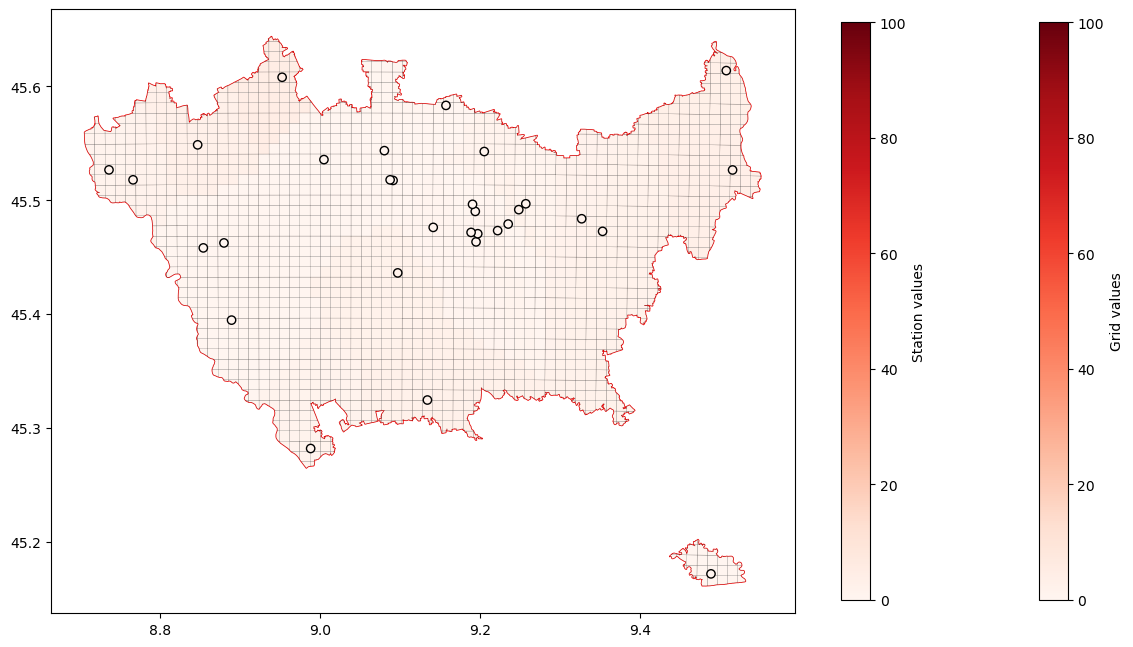

FOR pm10 MONTH 5
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


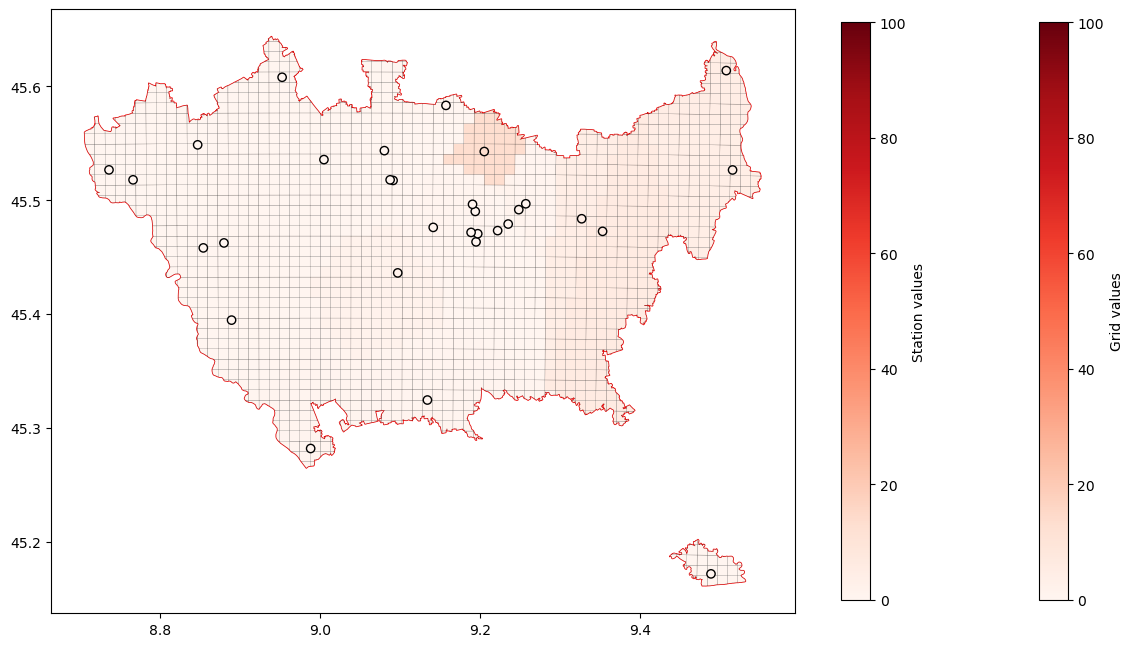

FOR pm10 MONTH 6
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


FOR pm10 MONTH 7
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


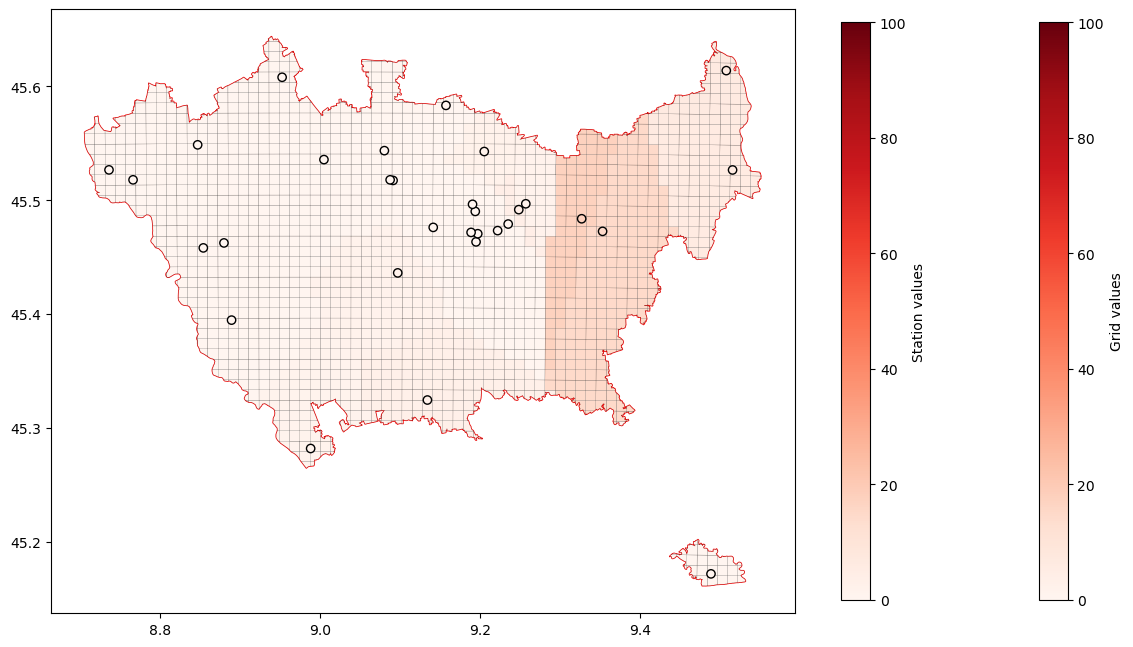

FOR pm10 MONTH 8
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


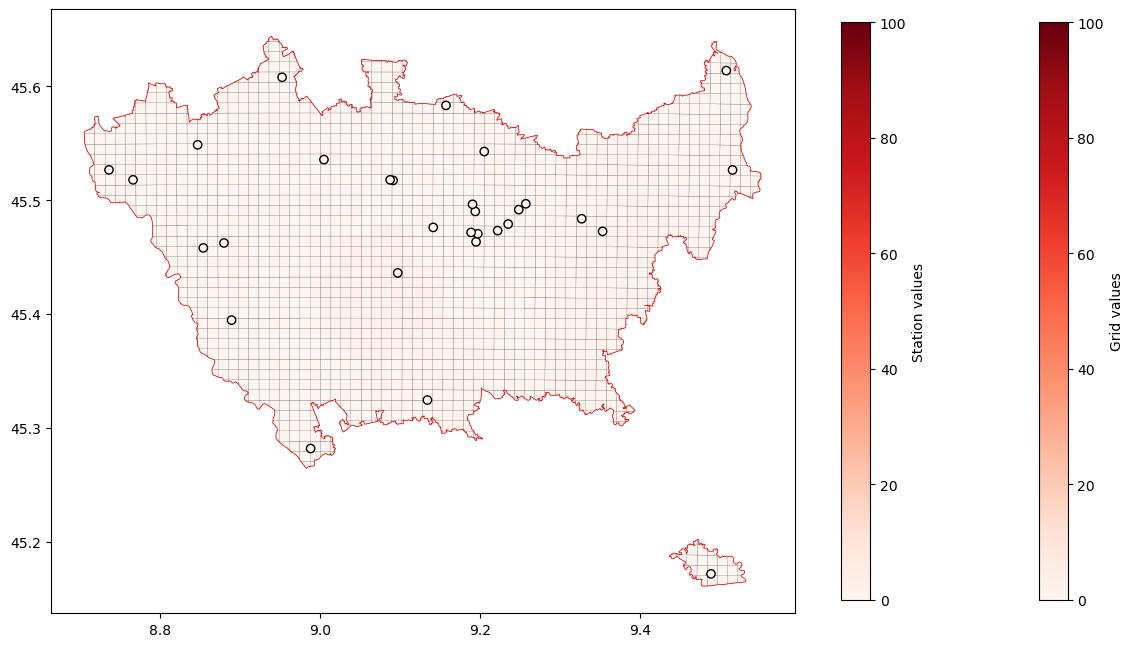

FOR pm10 MONTH 9
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


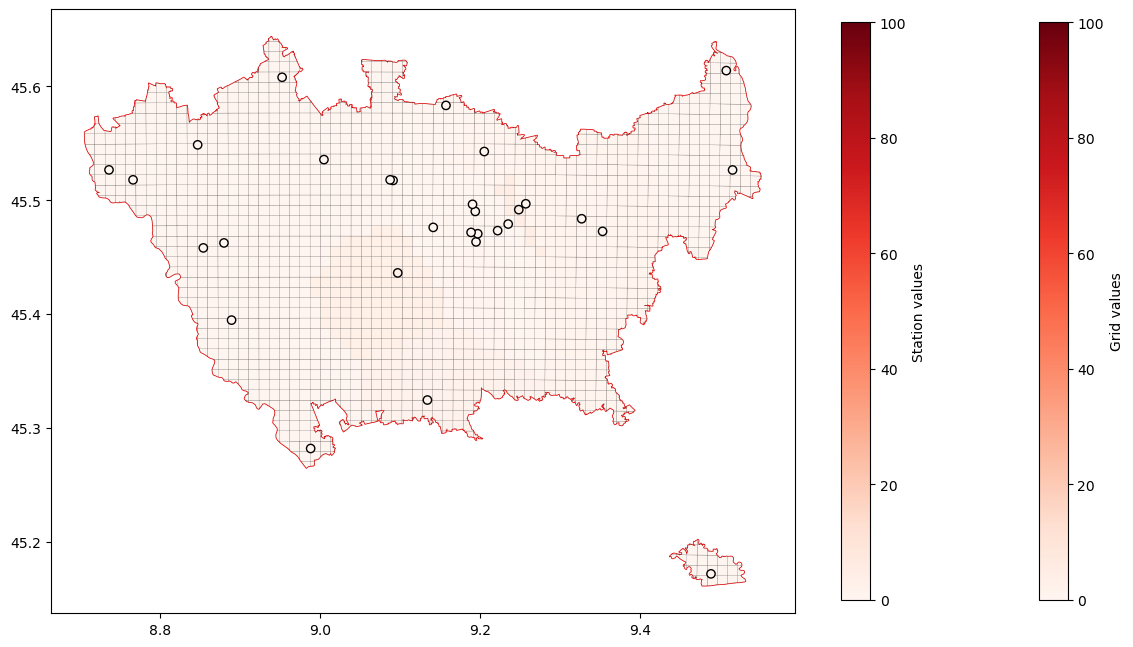

FOR pm10 MONTH 10
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


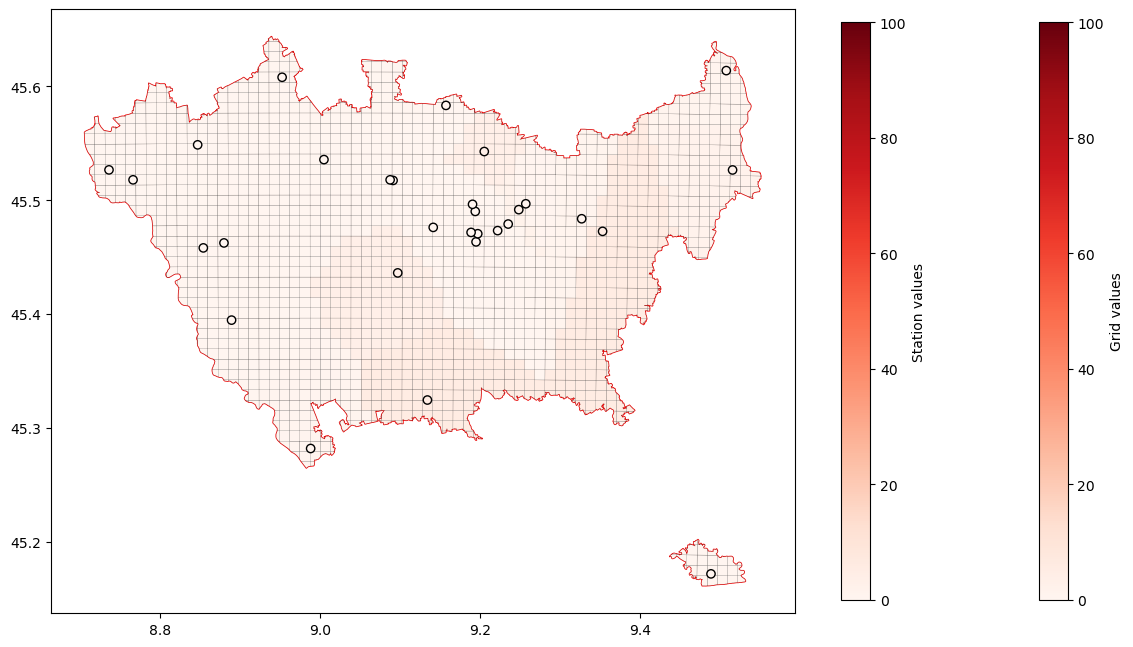

FOR pm10 MONTH 11
1/1 [==============================] - 0s 11ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


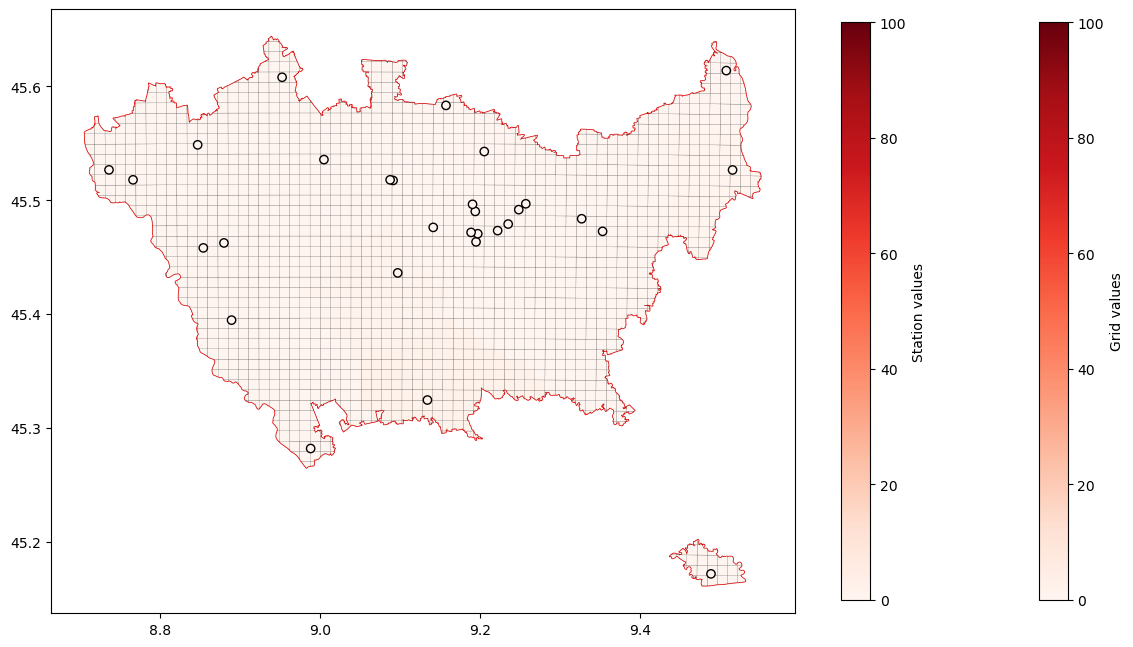

FOR pm10 MONTH 12
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


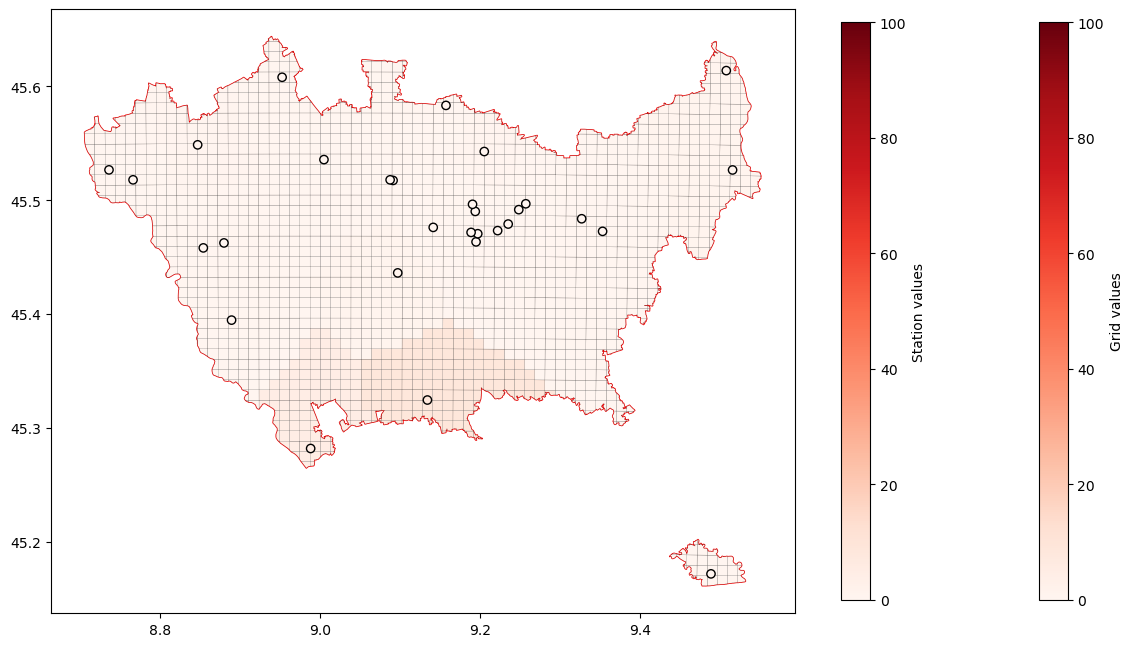

FOR pm25
Epoch 1/3


2023-10-31 11:06:58.712883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:06:58.713418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:06:58.713924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1099/1099 [==============================] - 2s 1ms/step - loss: 0.4524 - accuracy: 0.7838 - val_loss: 0.4130 - val_accuracy: 0.8123
Epoch 2/3
   1/1099 [..............................] - ETA: 1s - loss: 0.5014 - accuracy: 0.6719

2023-10-31 11:07:00.351551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:07:00.352564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:07:00.353196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1099/1099 [==============================] - 1s 936us/step - loss: 0.4185 - accuracy: 0.8072 - val_loss: 0.4175 - val_accuracy: 0.8103
Epoch 3/3
1099/1099 [==============================] - 1s 946us/step - loss: 0.4174 - accuracy: 0.8075 - val_loss: 0.4104 - val_accuracy: 0.8140
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               55200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 55,301
Trainable params: 55,301
Non-trainable params: 0
_________________________________________________________________
None
549/549 [==============================] - 0s 349us/step - loss: 0.4104 - accuracy: 0.8140
Test Loss: 0.4104466438293457, Test Accuracy: 0.8140262961387634
FOR p

2023-10-31 11:07:02.928844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:07:02.929577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:07:02.930031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


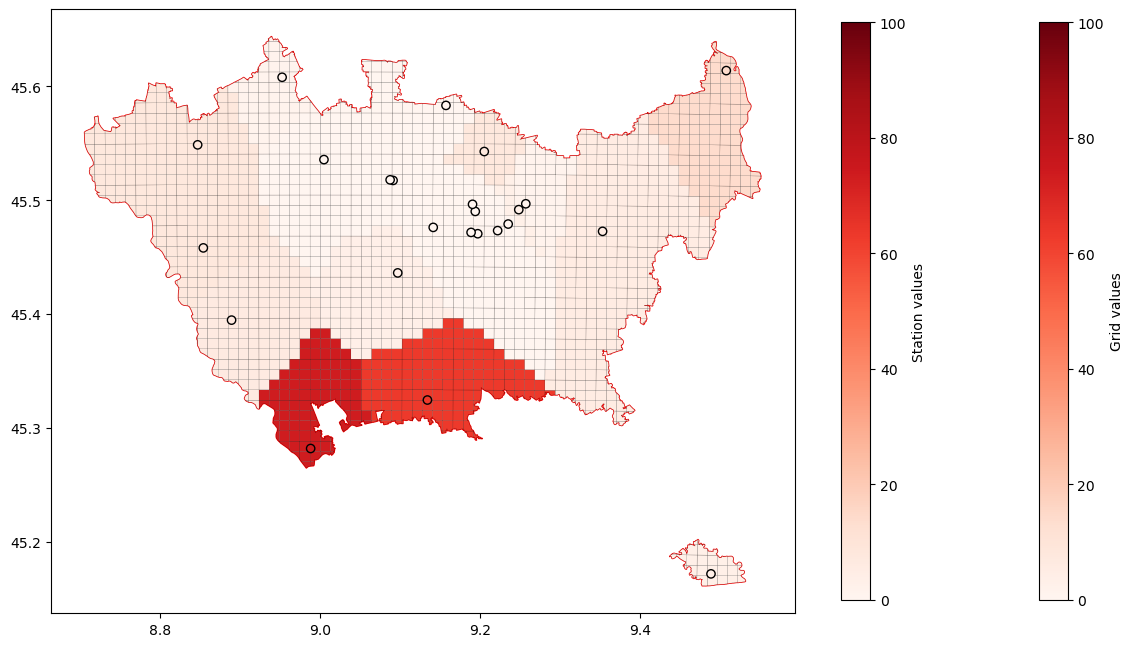

FOR pm25 MONTH 2
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


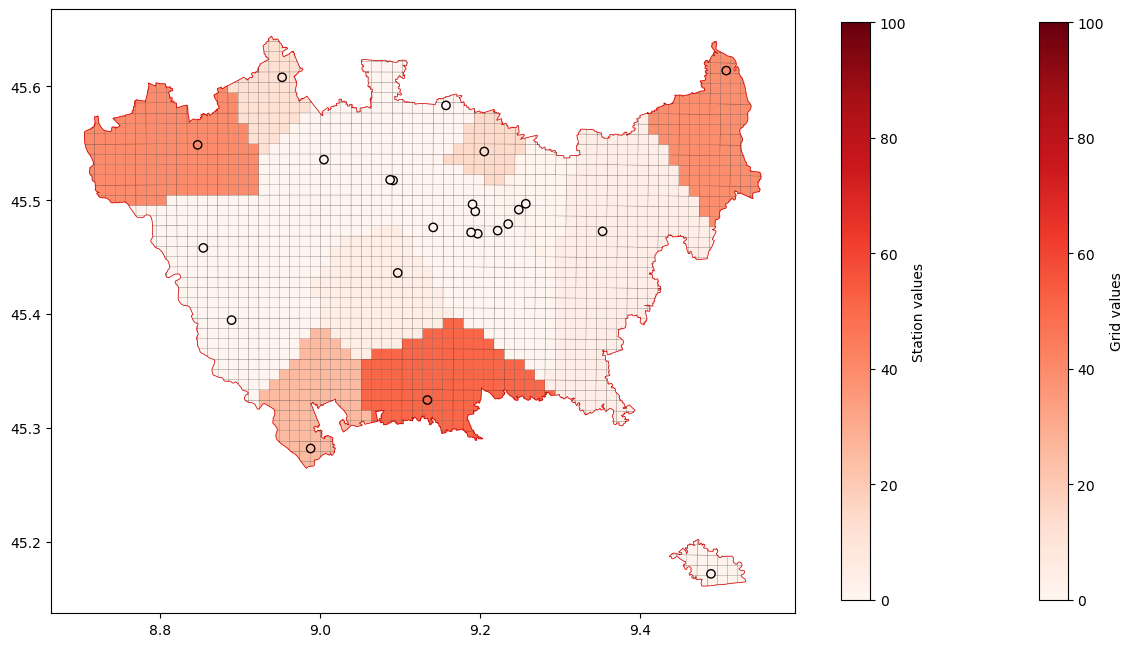

FOR pm25 MONTH 3
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


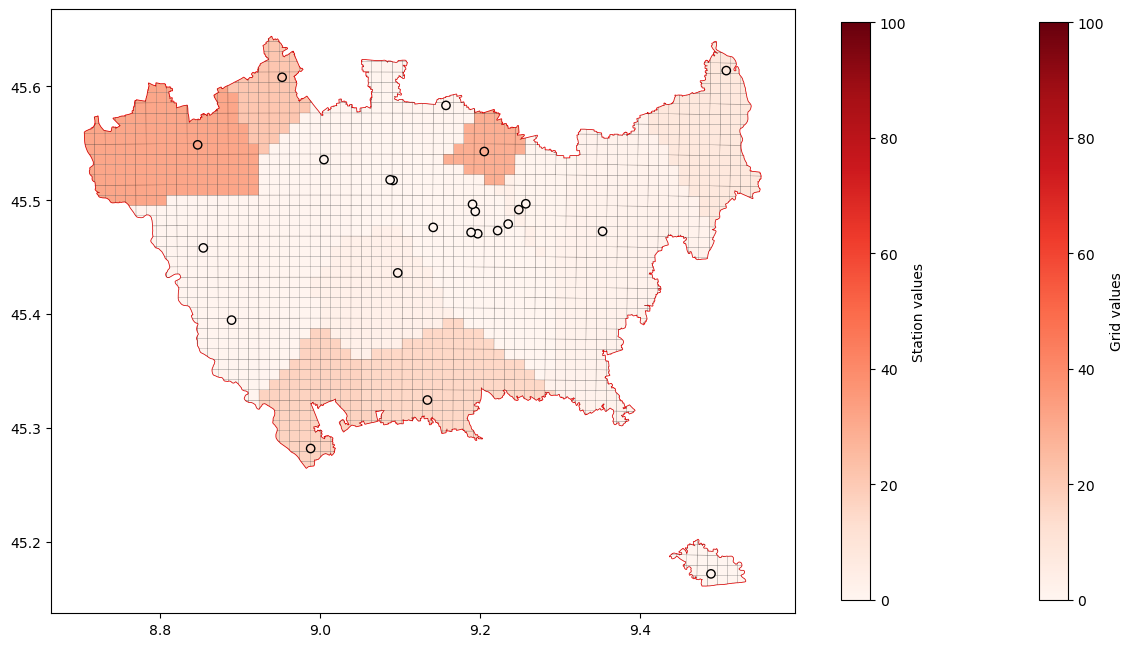

FOR pm25 MONTH 4
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


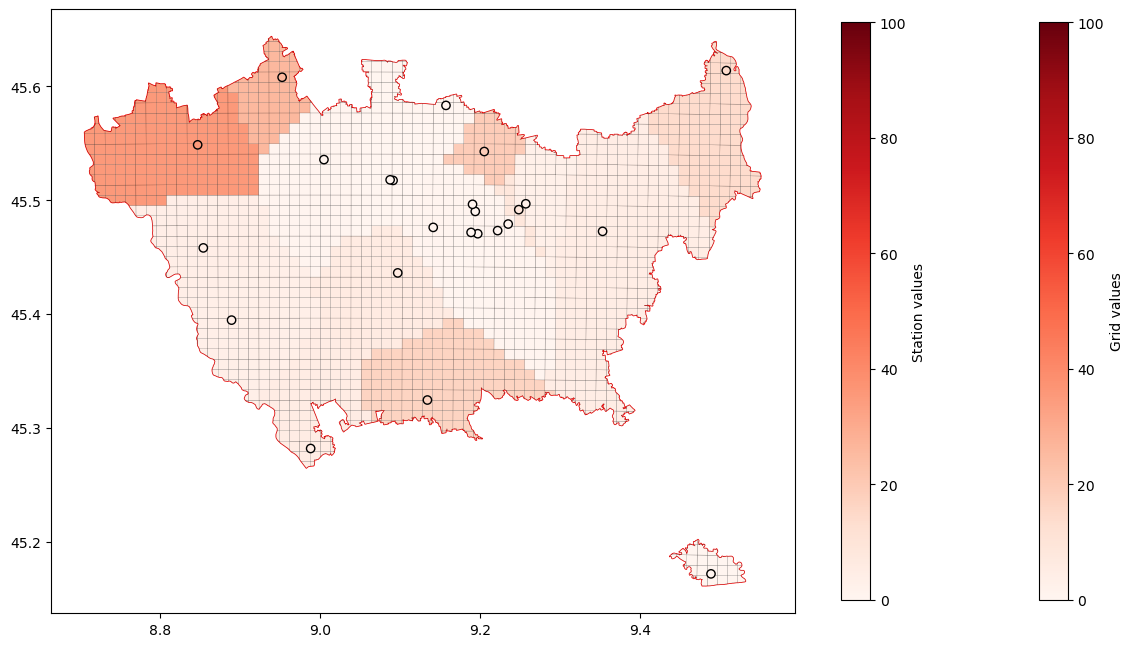

FOR pm25 MONTH 5
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


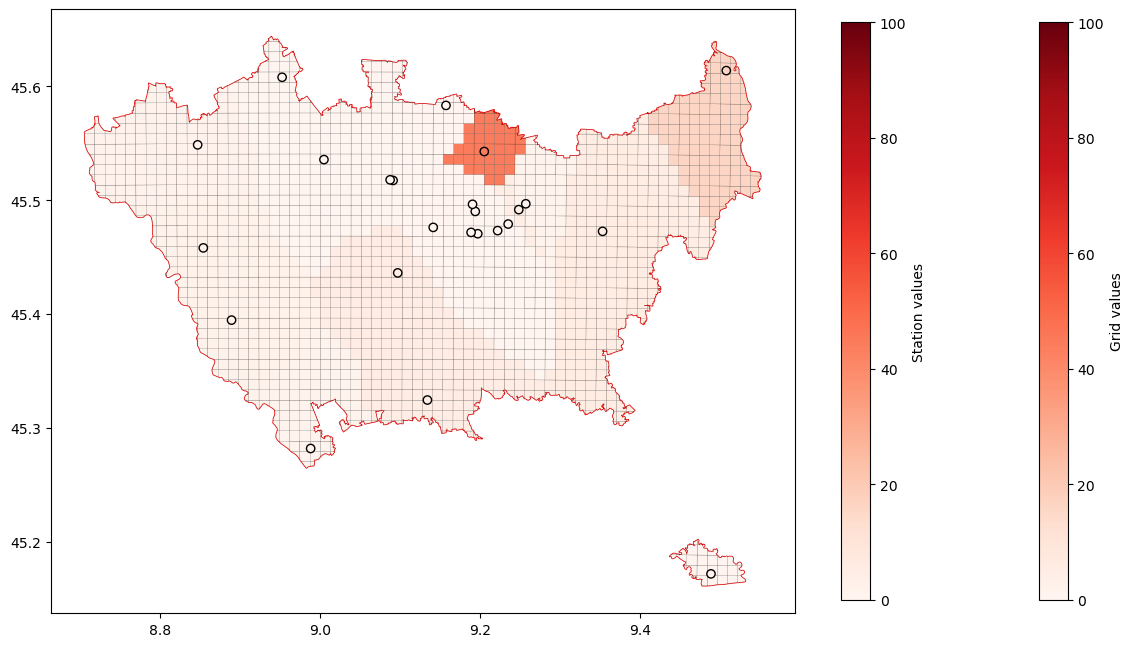

FOR pm25 MONTH 6
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


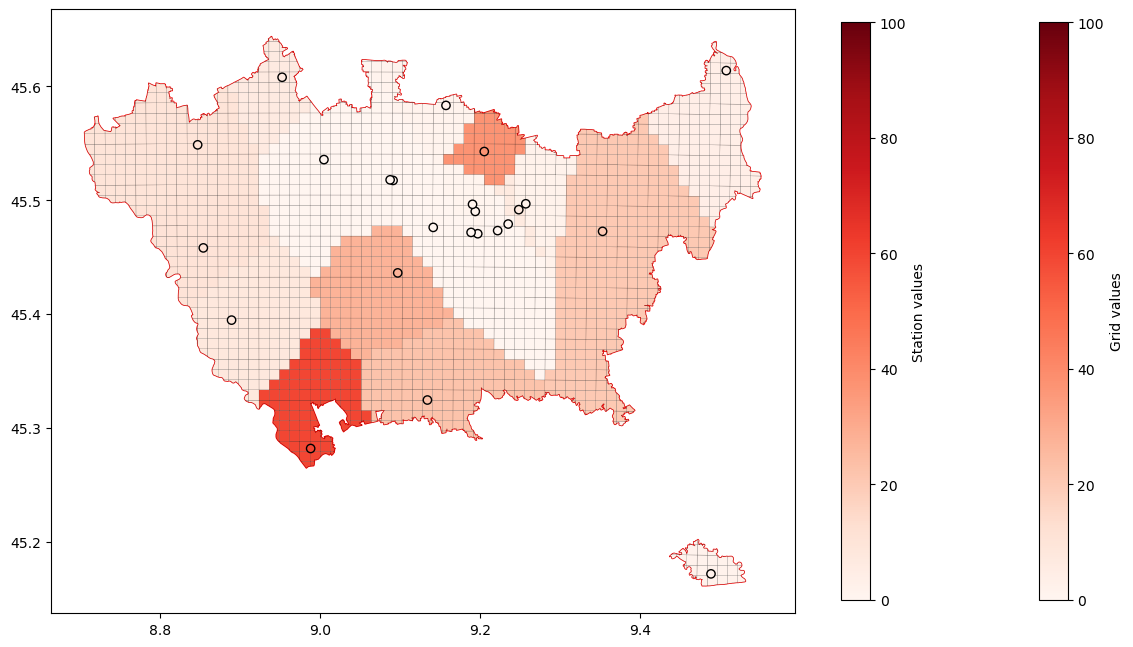

FOR pm25 MONTH 7
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


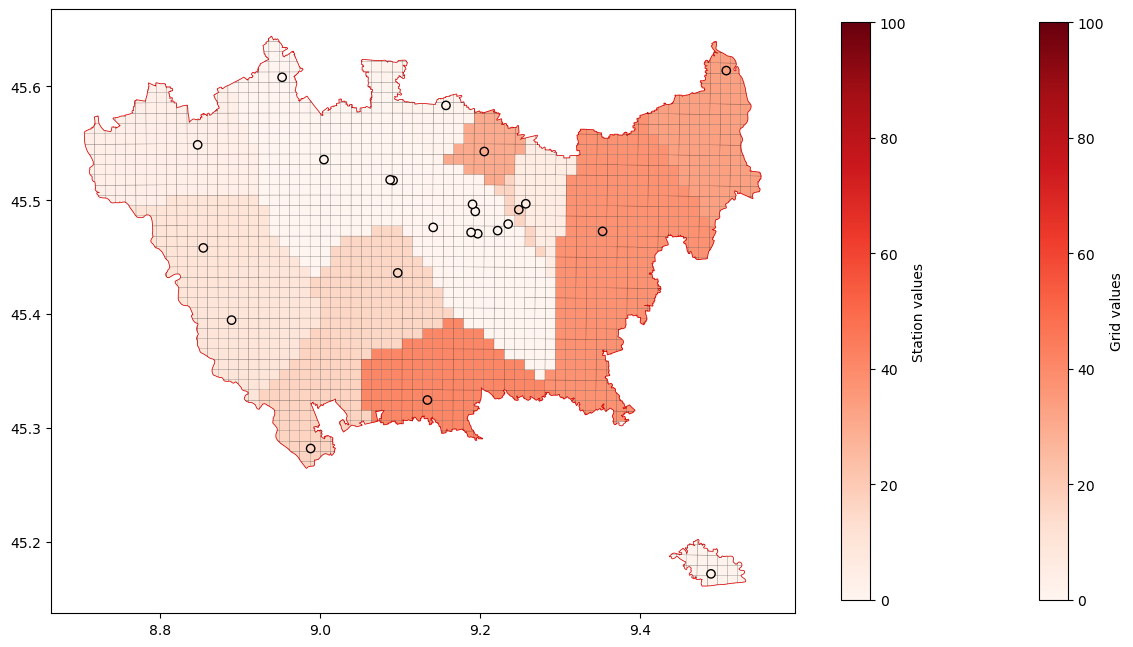

FOR pm25 MONTH 8
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


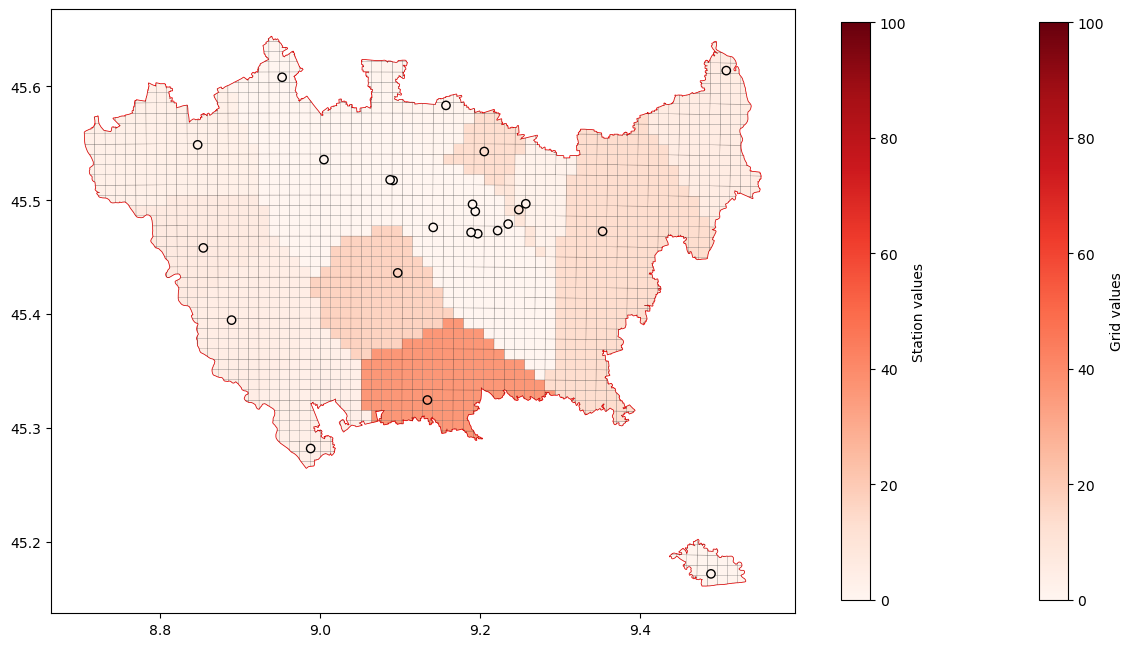

FOR pm25 MONTH 9
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


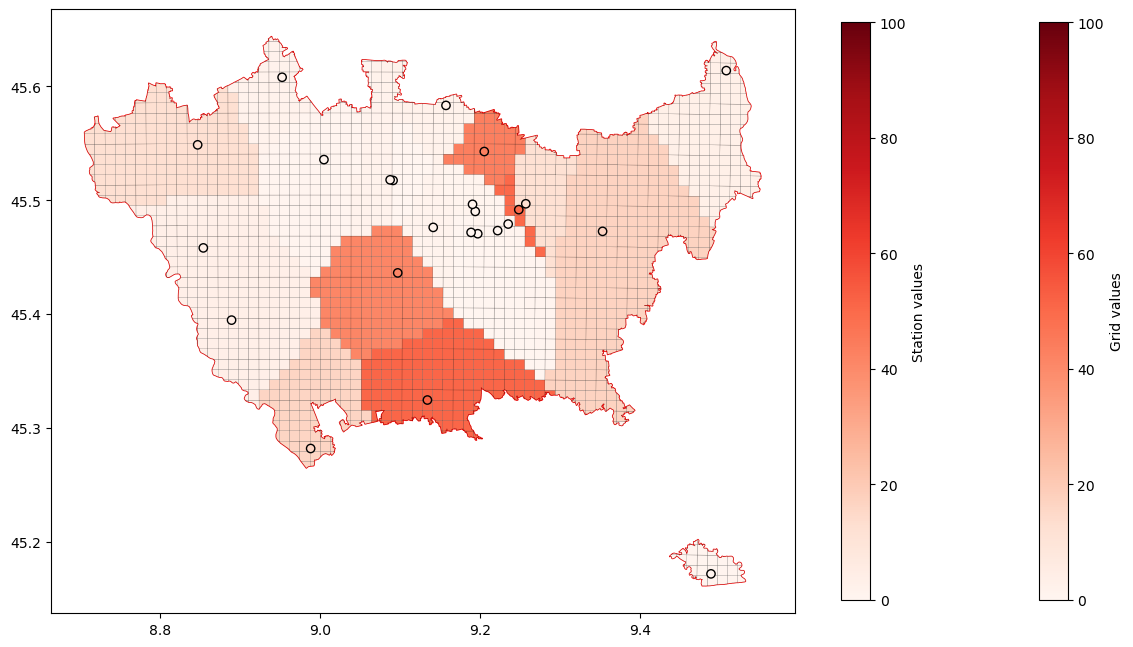

FOR pm25 MONTH 10
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


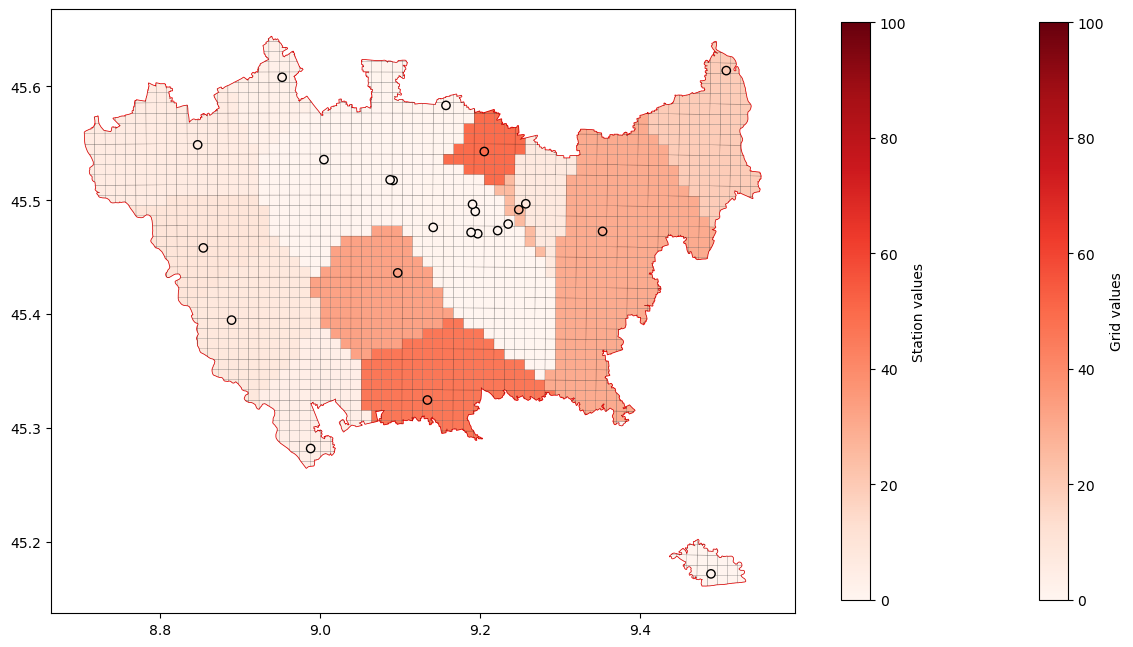

FOR pm25 MONTH 11
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


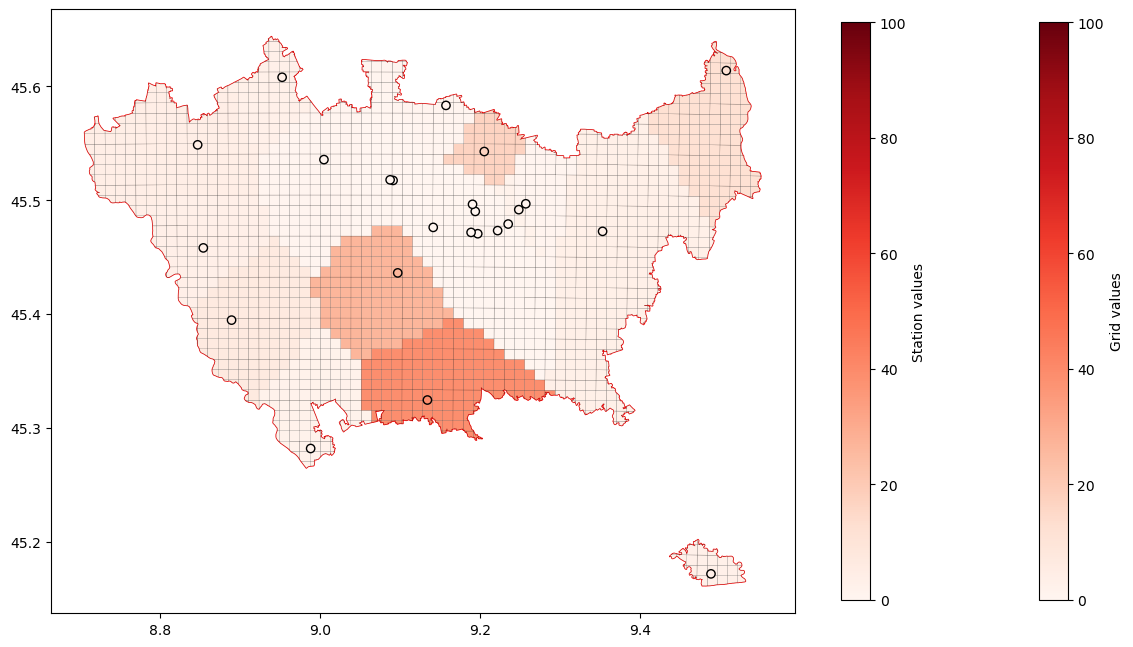

FOR pm25 MONTH 12
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


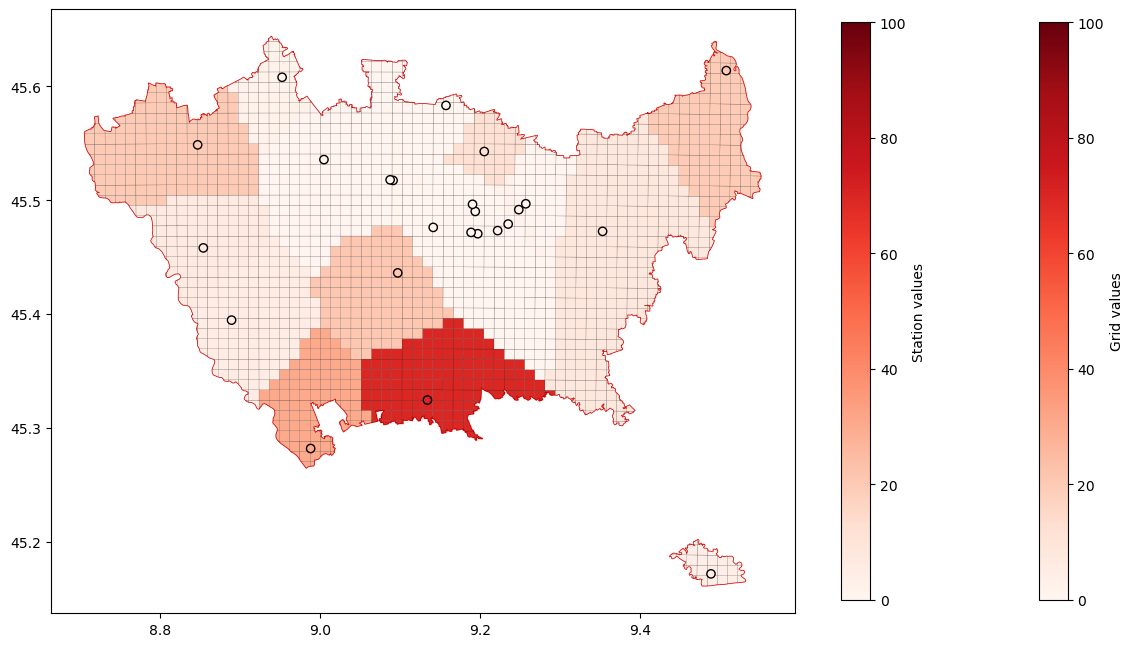

FOR so2
Epoch 1/3


2023-10-31 11:07:23.597084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:07:23.597631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:07:23.598379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1290/1290 [==============================] - 2s 1ms/step - loss: 0.0427 - accuracy: 0.9945 - val_loss: 0.0282 - val_accuracy: 0.9948
Epoch 2/3
   1/1290 [..............................] - ETA: 1s - loss: 0.0710 - accuracy: 0.9844

2023-10-31 11:07:25.388866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:07:25.389560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:07:25.389985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1290/1290 [==============================] - 1s 929us/step - loss: 0.0277 - accuracy: 0.9948 - val_loss: 0.0259 - val_accuracy: 0.9948
Epoch 3/3
1290/1290 [==============================] - 1s 917us/step - loss: 0.0261 - accuracy: 0.9948 - val_loss: 0.0257 - val_accuracy: 0.9948
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100)               55200     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 55,301
Trainable params: 55,301
Non-trainable params: 0
_________________________________________________________________
None
645/645 [==============================] - 0s 345us/step - loss: 0.0257 - accuracy: 0.9948
Test Loss: 0.02568318508565426, Test Accuracy: 0.9948128461837769
FOR 

2023-10-31 11:07:28.298592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:07:28.299398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:07:28.299918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


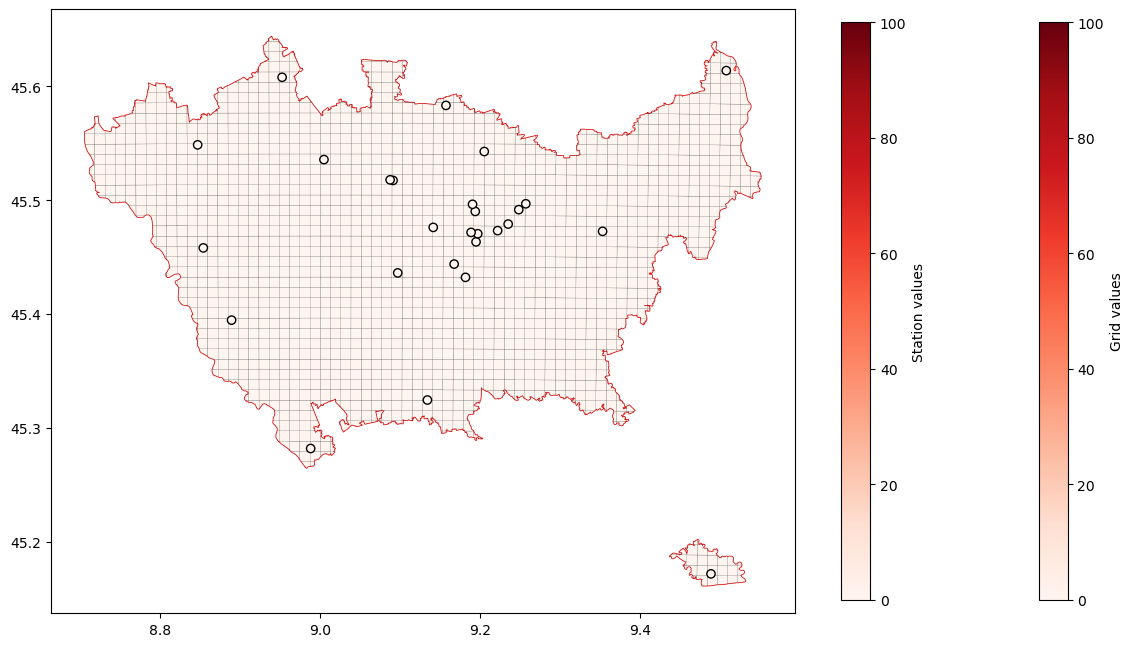

FOR so2 MONTH 2
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


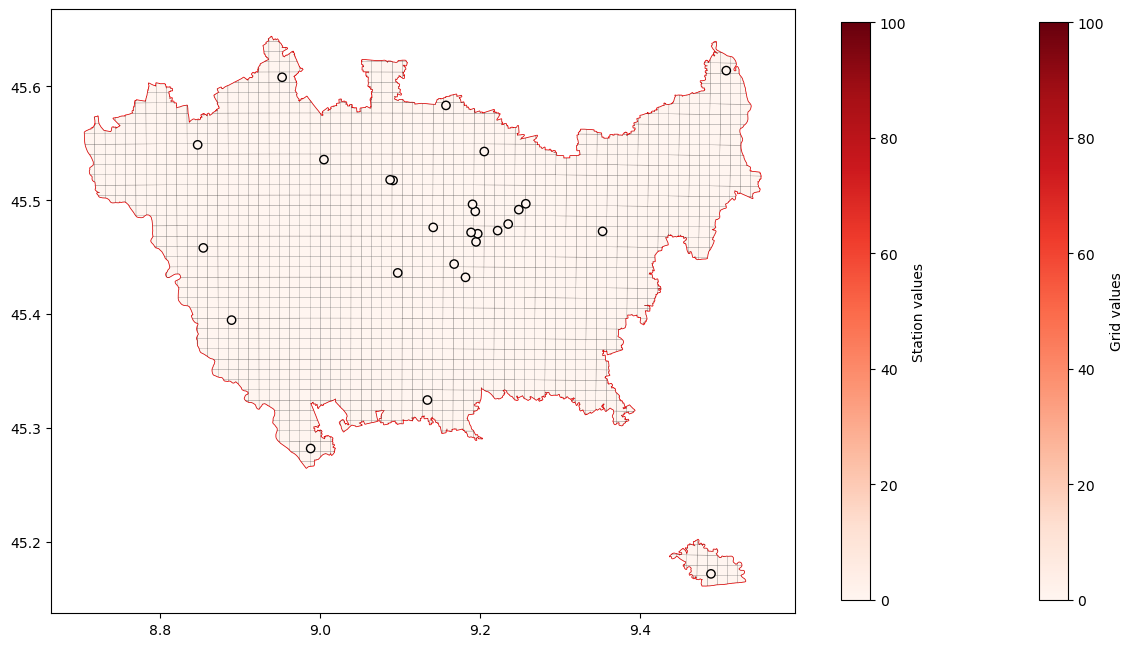

FOR so2 MONTH 3
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


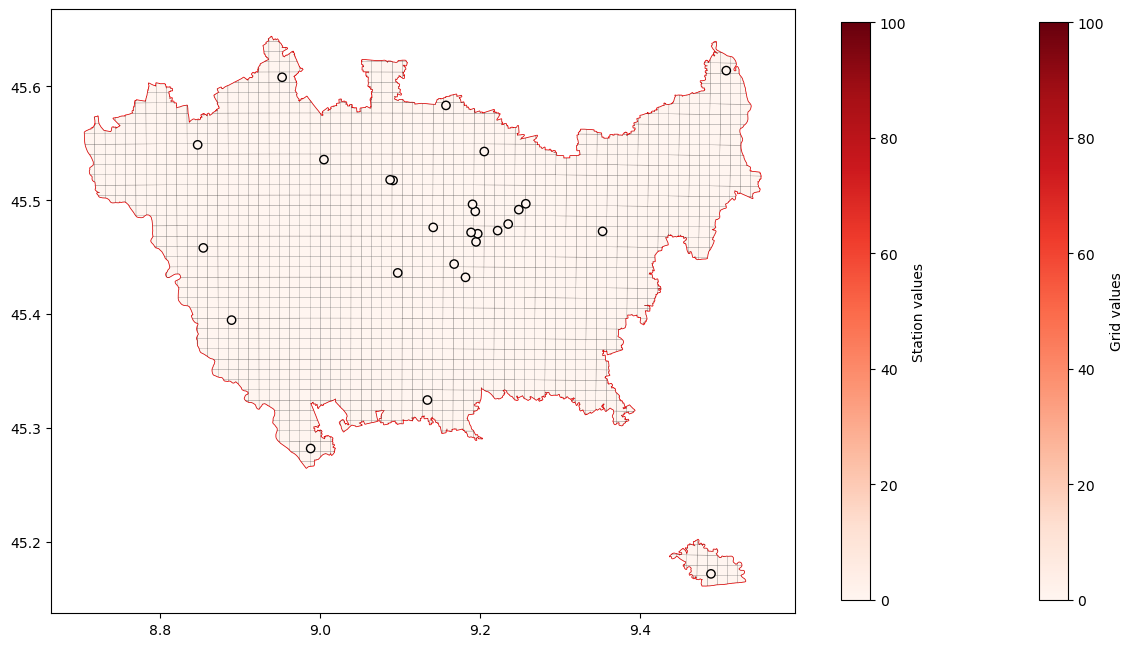

FOR so2 MONTH 4
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


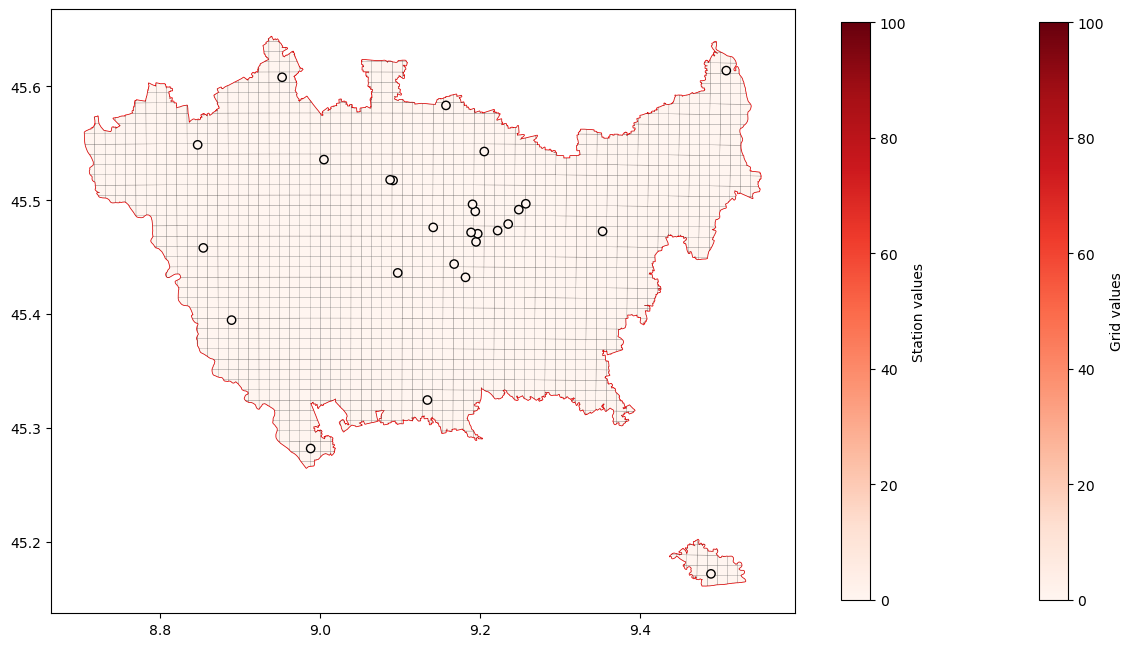

FOR so2 MONTH 5
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


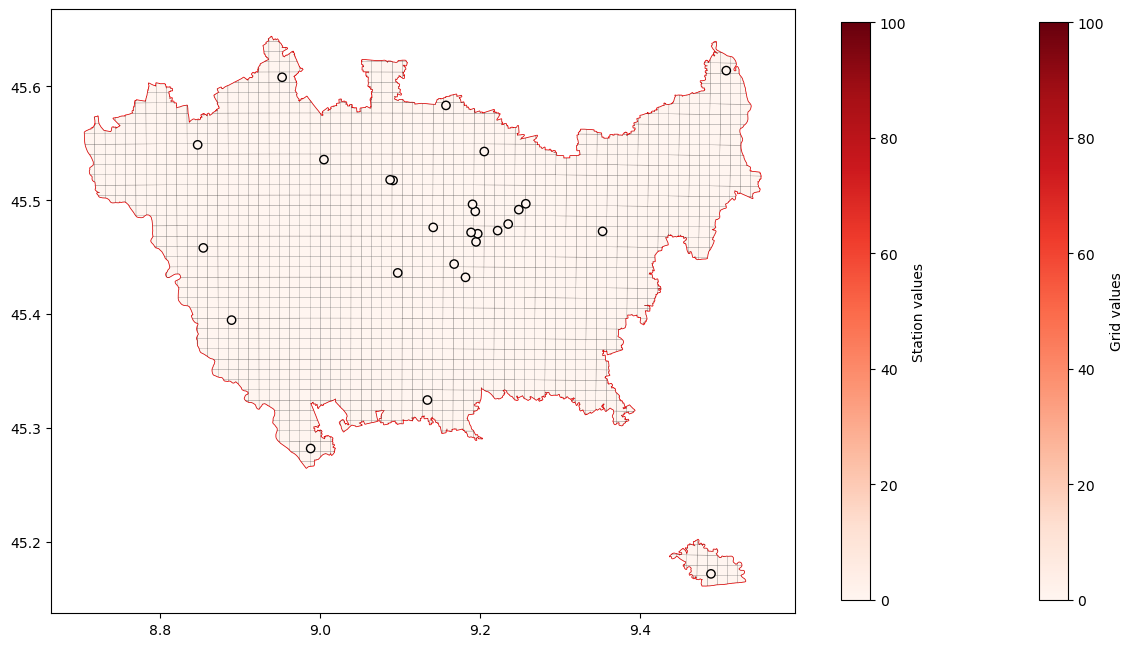

FOR so2 MONTH 6
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


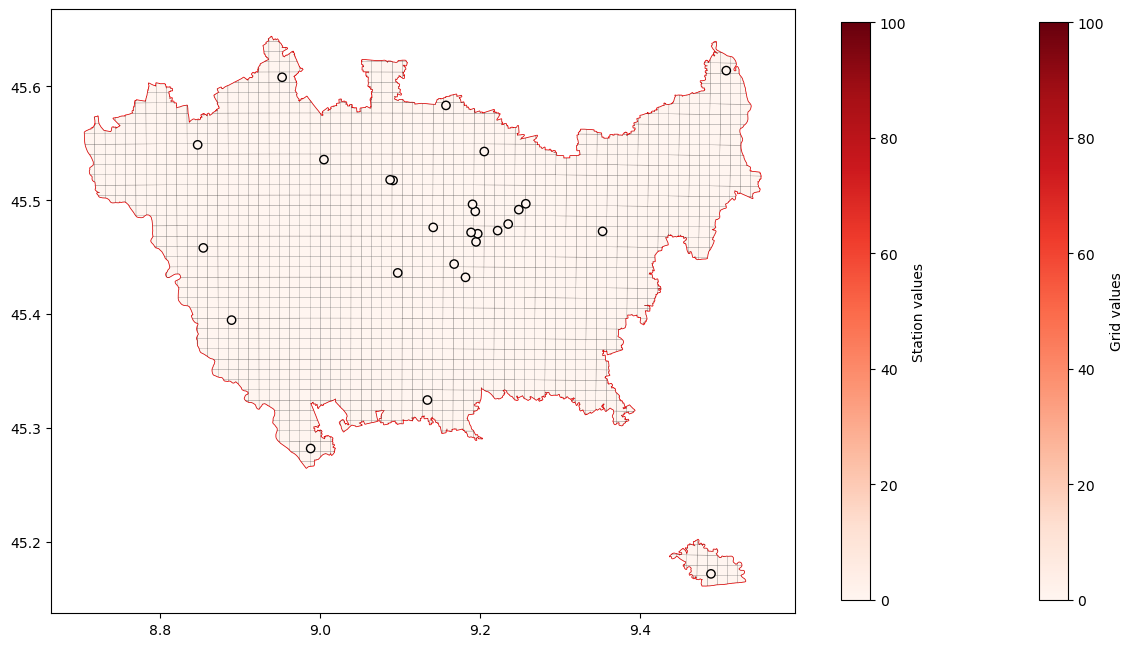

FOR so2 MONTH 7
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


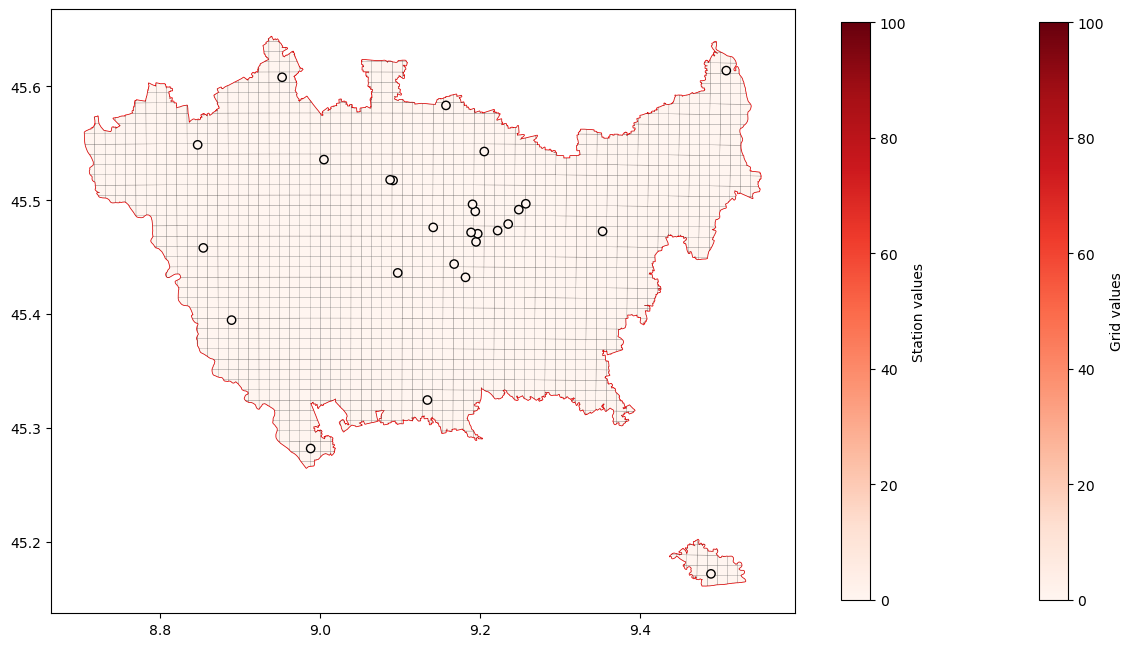

FOR so2 MONTH 8
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


FOR so2 MONTH 9
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


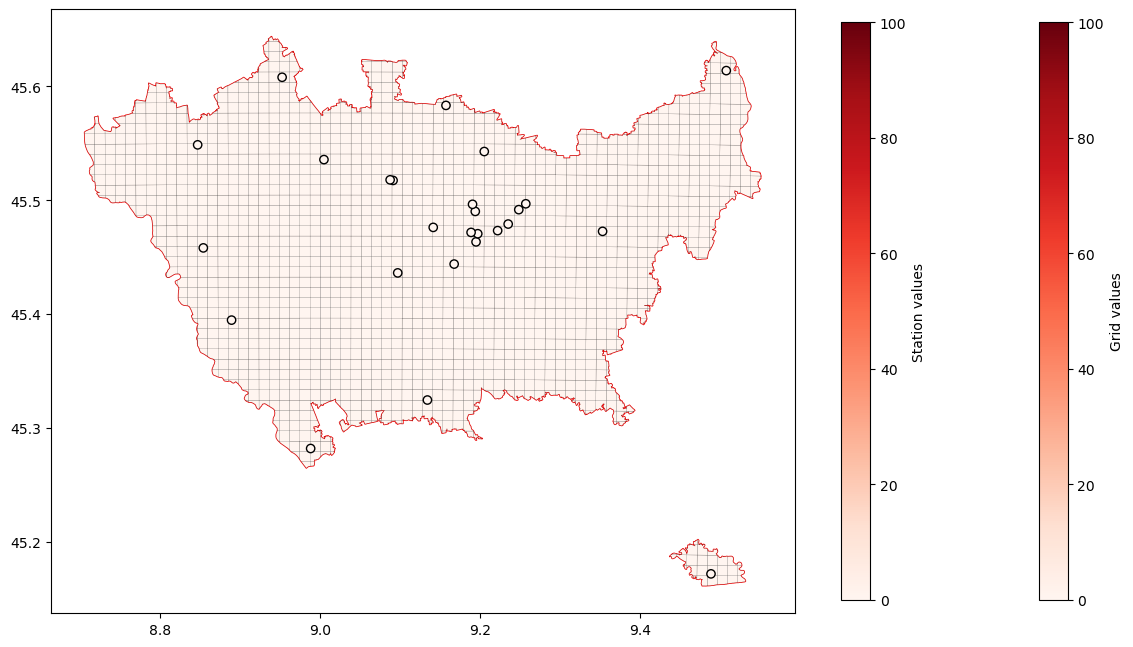

FOR so2 MONTH 10
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


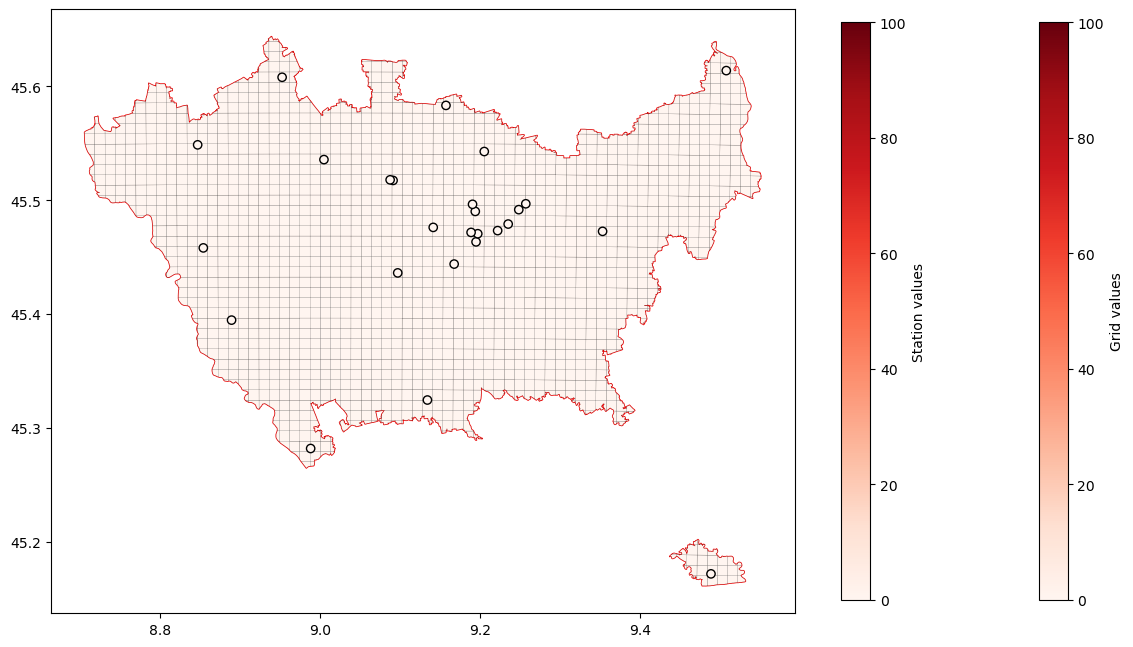

FOR so2 MONTH 11
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


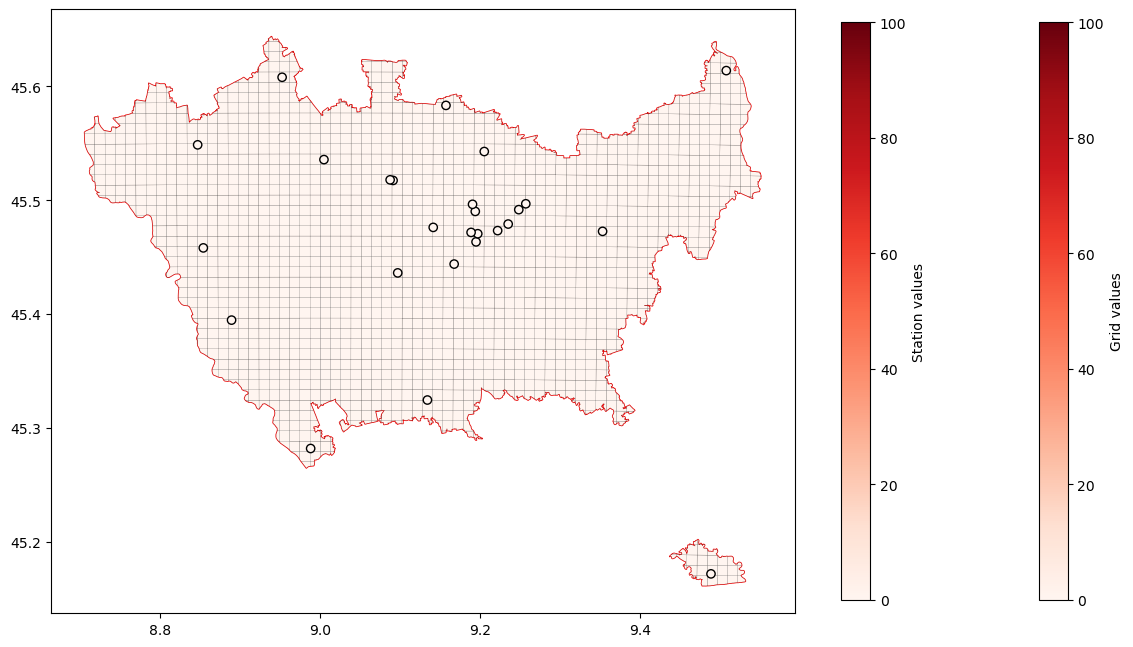

FOR so2 MONTH 12
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


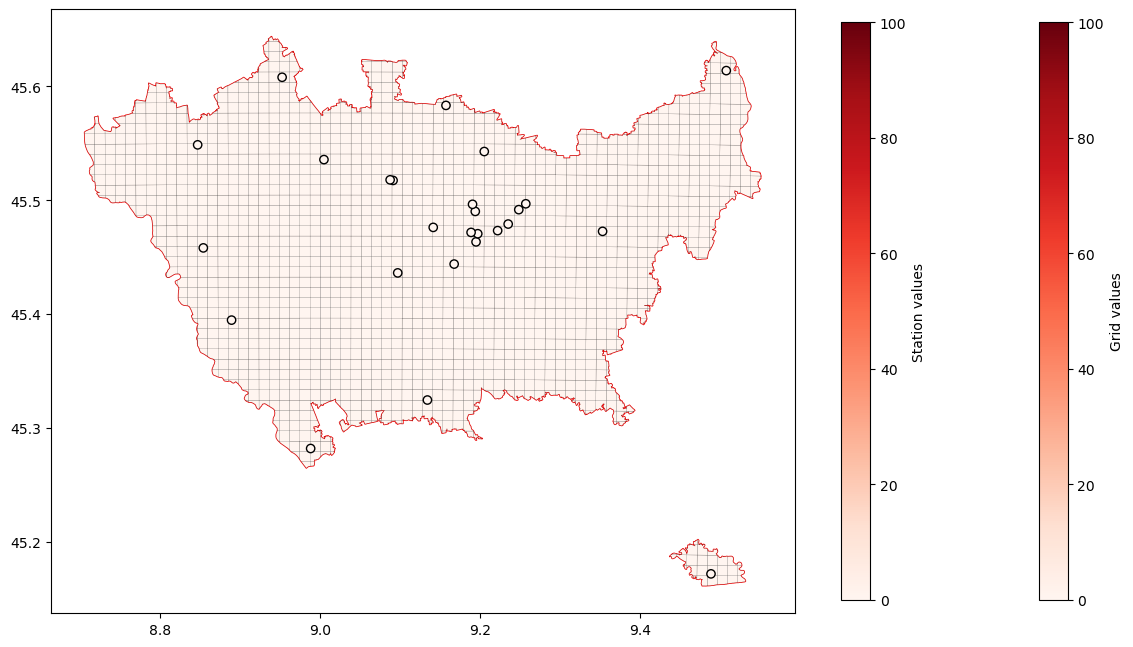

FOR o3
Epoch 1/3


2023-10-31 11:07:49.074434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:07:49.075056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:07:49.075520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1148/1148 [==============================] - 2s 1ms/step - loss: 0.0208 - accuracy: 0.9991 - val_loss: 0.0060 - val_accuracy: 0.9993
Epoch 2/3
   1/1148 [..............................] - ETA: 1s - loss: 7.0733e-04 - accuracy: 1.0000

2023-10-31 11:07:50.796004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:07:50.796607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:07:50.797154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1148/1148 [==============================] - 1s 902us/step - loss: 0.0061 - accuracy: 0.9993 - val_loss: 0.0056 - val_accuracy: 0.9993
Epoch 3/3
1148/1148 [==============================] - 1s 952us/step - loss: 0.0058 - accuracy: 0.9993 - val_loss: 0.0054 - val_accuracy: 0.9993
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               55200     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 55,301
Trainable params: 55,301
Non-trainable params: 0
_________________________________________________________________
None
574/574 [==============================] - 0s 366us/step - loss: 0.0054 - accuracy: 0.9993
Test Loss: 0.005362795665860176, Test Accuracy: 0.9993464946746826
FOR

2023-10-31 11:07:53.427448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-31 11:07:53.428224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-31 11:07:53.428713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


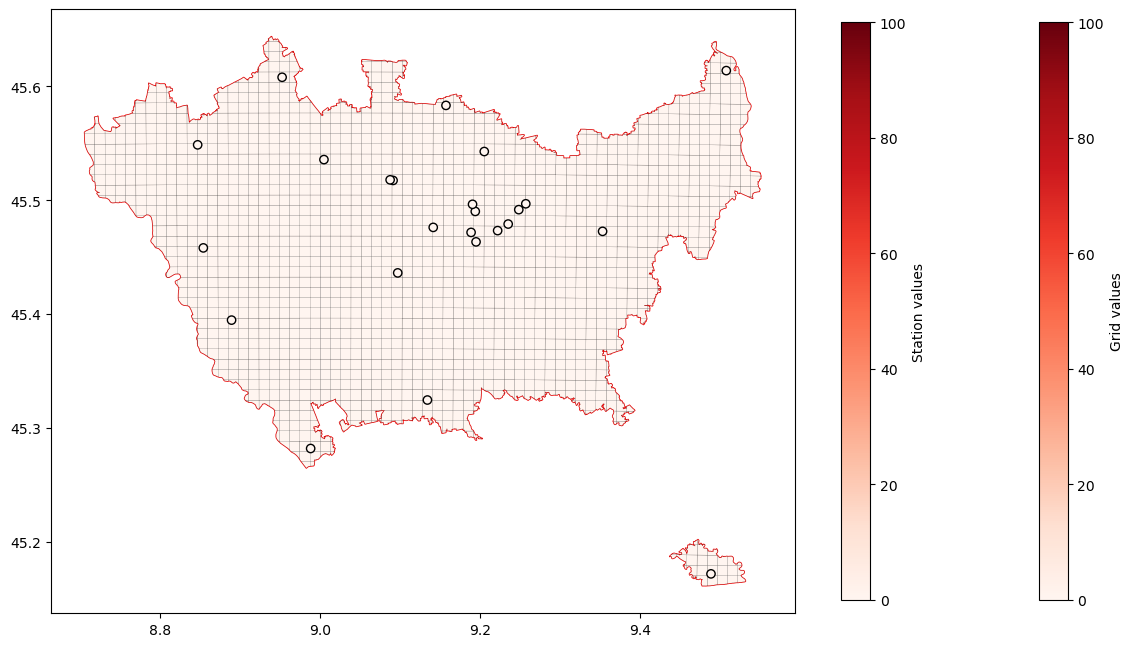

FOR o3 MONTH 2
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


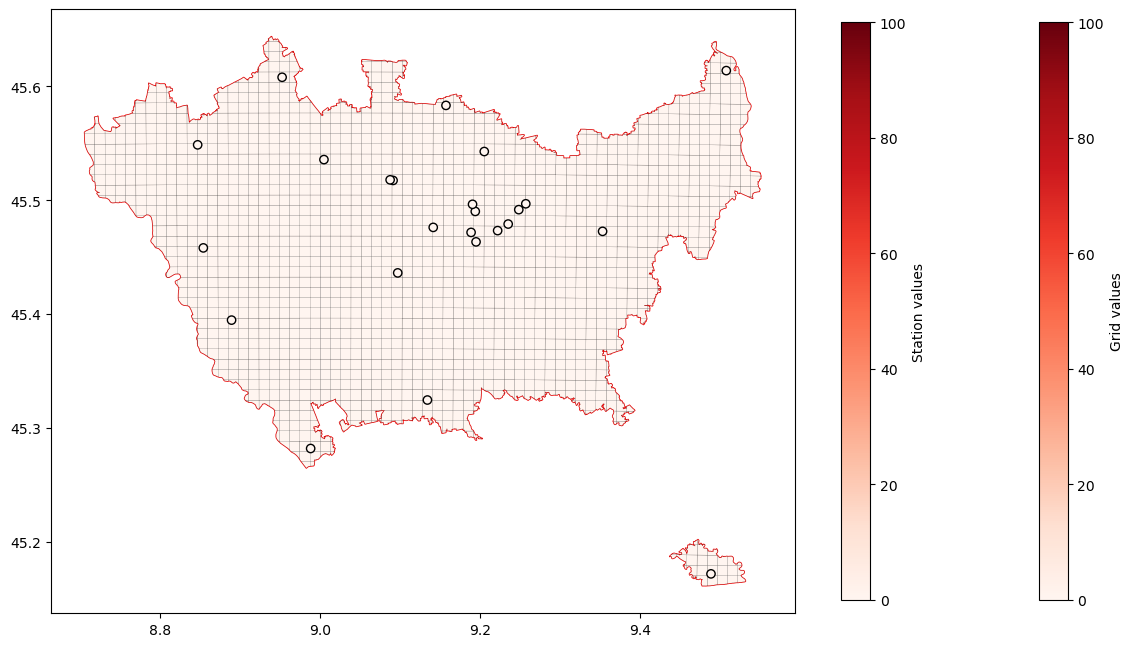

FOR o3 MONTH 3
1/1 [==============================] - 0s 11ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


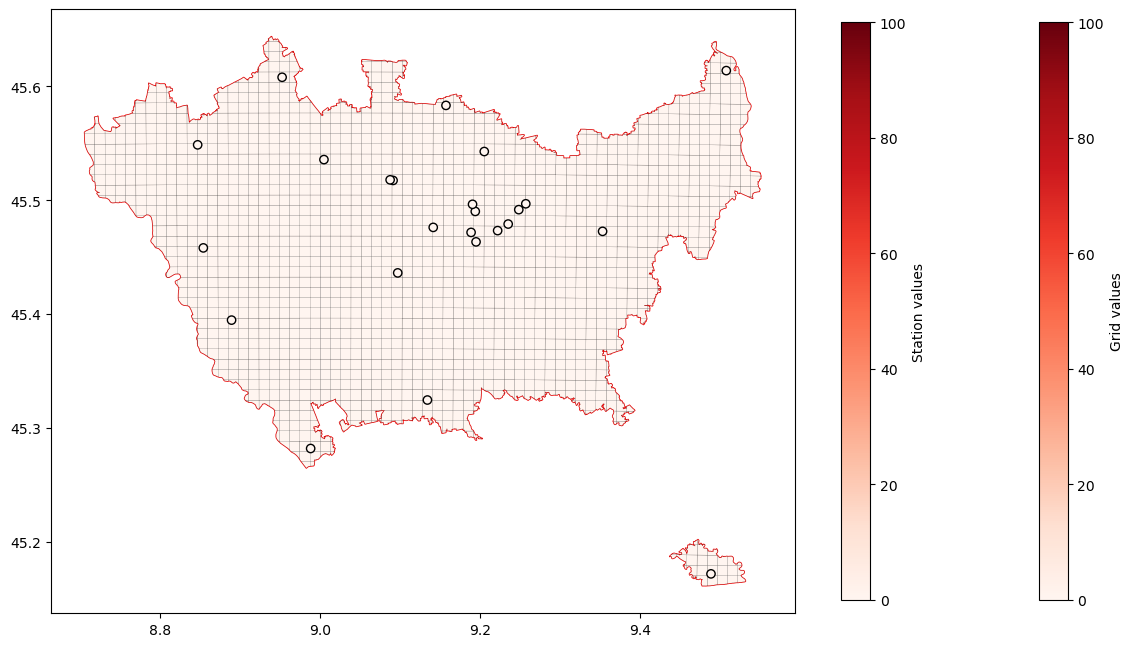

FOR o3 MONTH 4
1/1 [==============================] - 0s 12ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


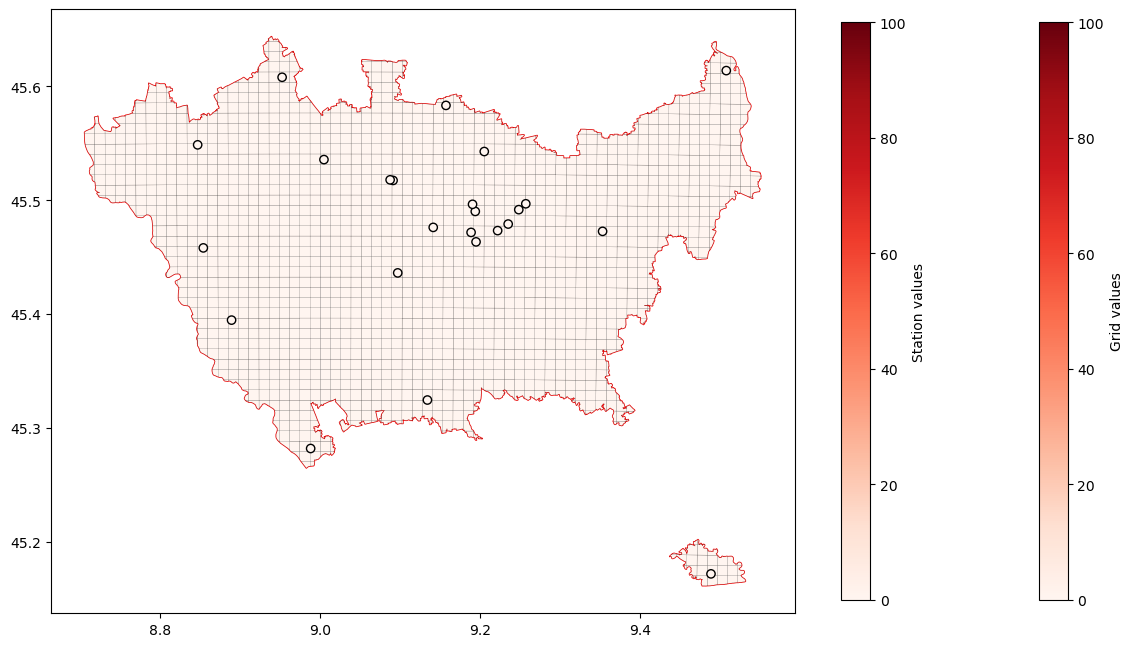

FOR o3 MONTH 5
1/1 [==============================] - 0s 11ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


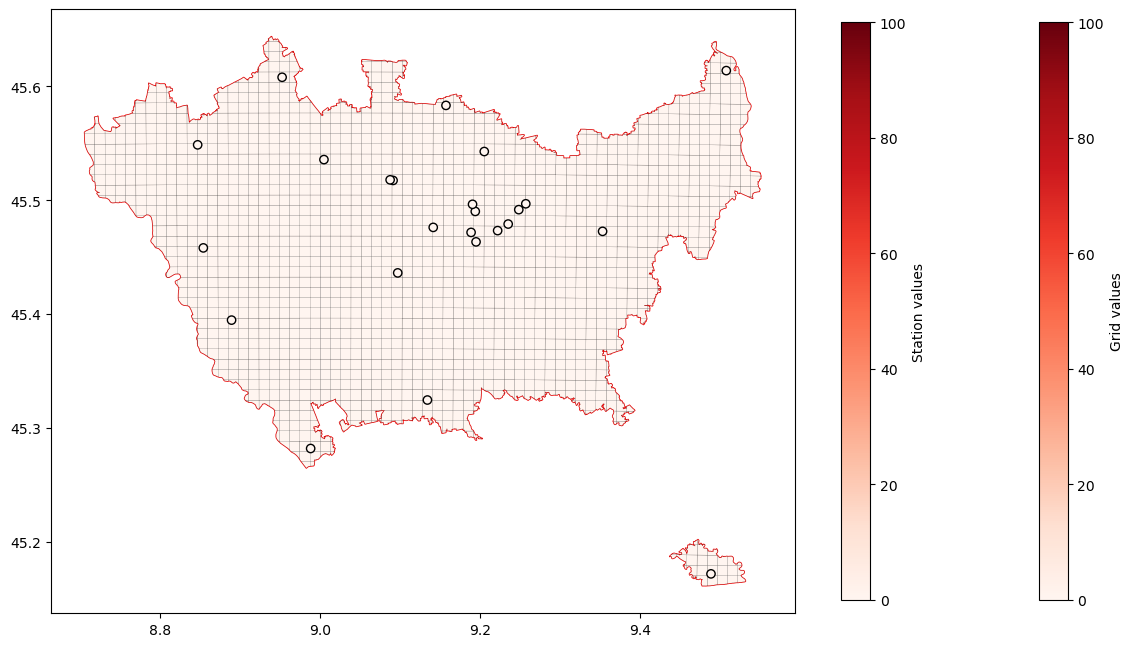

FOR o3 MONTH 6
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


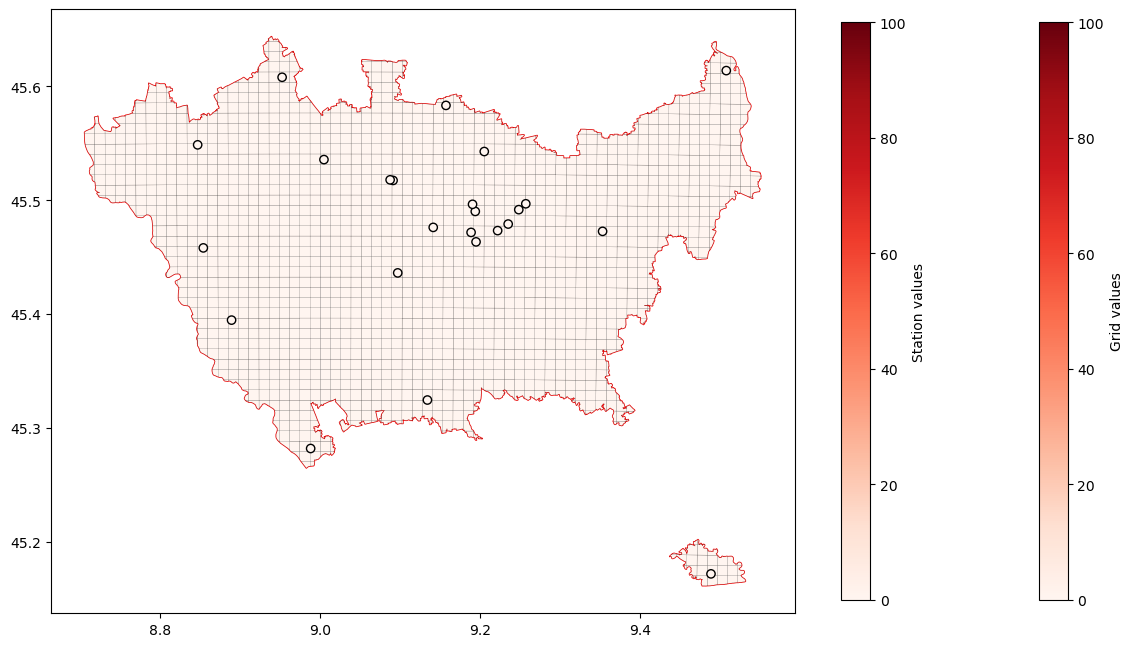

FOR o3 MONTH 7
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


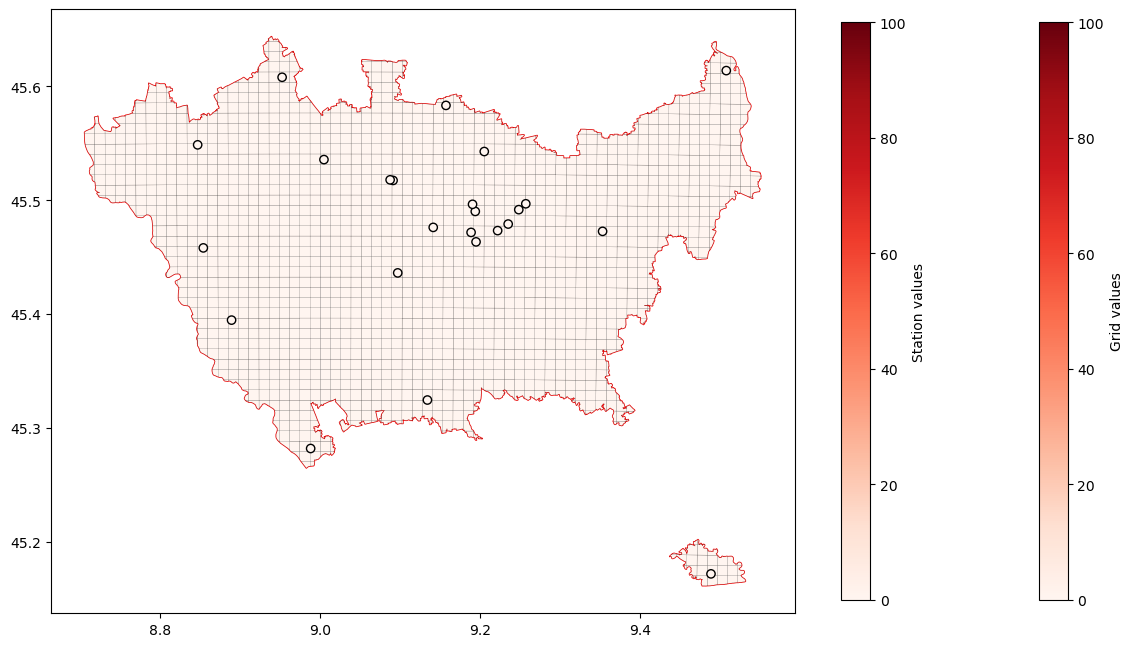

FOR o3 MONTH 8
1/1 [==============================] - 0s 10ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


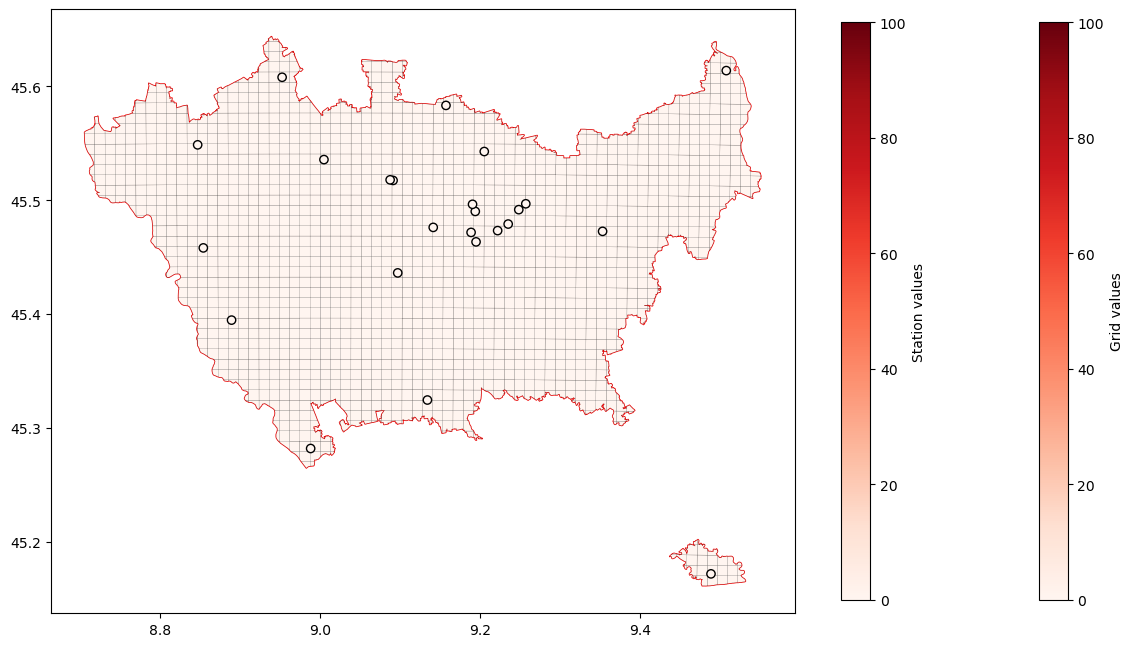

FOR o3 MONTH 9
1/1 [==============================] - 0s 12ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


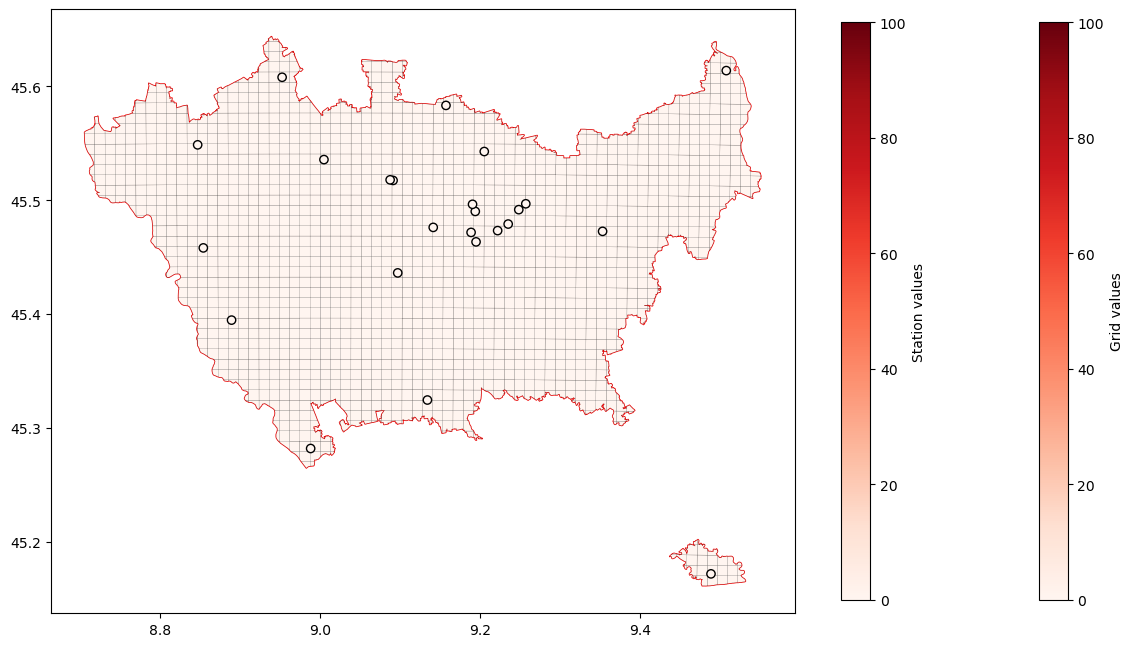

FOR o3 MONTH 10
1/1 [==============================] - 0s 11ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


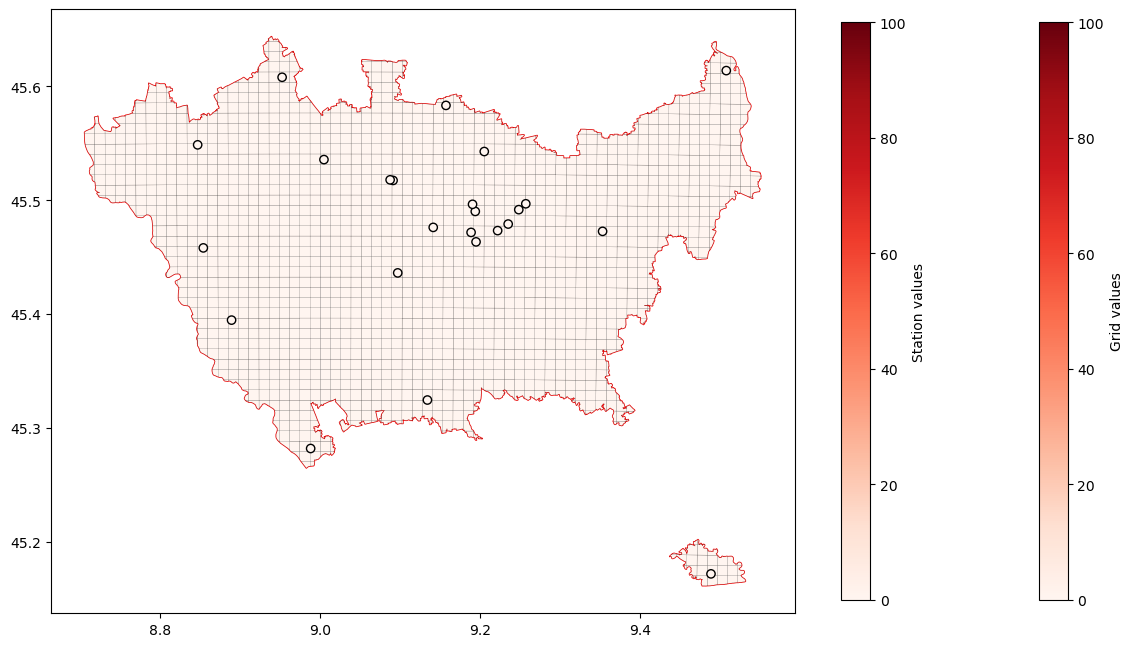

FOR o3 MONTH 11
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


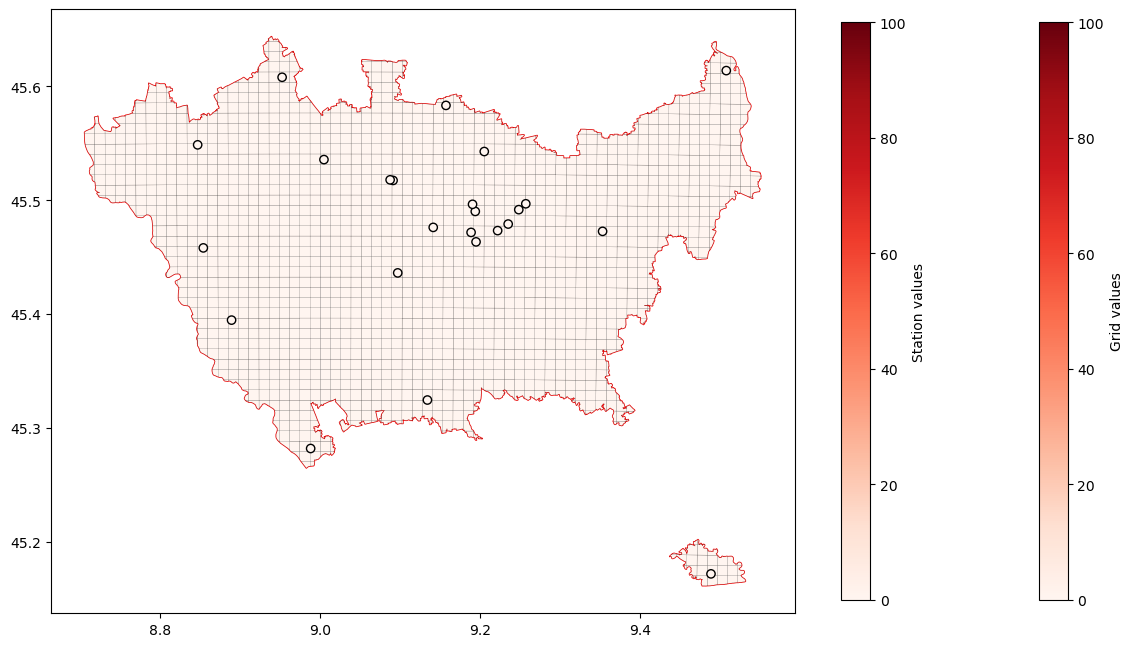

FOR o3 MONTH 12
1/1 [==============================] - 0s 9ms/step
Reading shapefile ../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp
epsg:32632
Converting data to geodataframe
The grid of the shapefile was created and the station points have been georeferrenced
Creating an interpolation with the Nearest Neighbour method
Plotting the results...


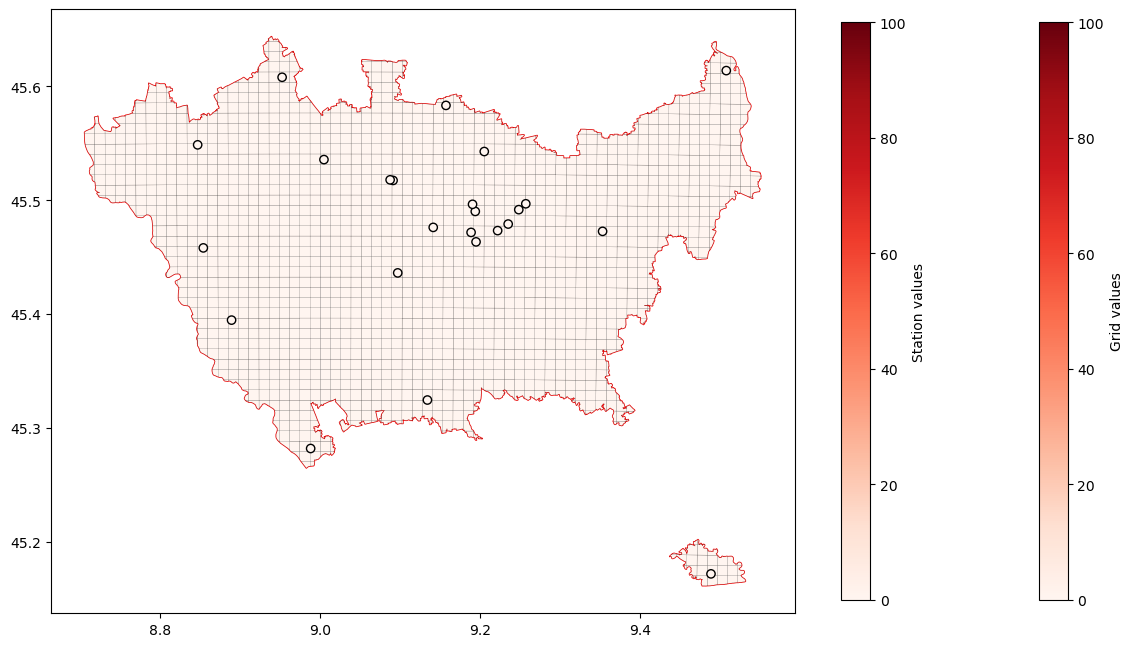

In [11]:
importer = processing.HarmoniaProcessor()
#pollutants = ['pm10', 'pm25', 'no2', 'so2', 'o3']
pollutants = ['pm10', 'pm25', 'so2', 'o3']
for pollutant in pollutants:
    print(f"FOR {pollutant}")

    train_path = f'../data/MILANO/harmonia_processor/{pollutant}/train/training_rand_balance.csv'
    training_dataset = importer.import_df(train_path, date_format='%Y-%m-%d')
    training_dataset = training_dataset.dropna()
    training_dates = training_dataset.copy()[['date']]
    if 'date' in list(training_dataset.columns):
        training_dataset = training_dataset.drop(['date'], axis=1)

    test_path = f'../data/MILANO/harmonia_processor/{pollutant}/train/validation_rand_balance.csv'
    testing_dataset = importer.import_df(test_path, date_format='%Y-%m-%d')
    testing_dataset = testing_dataset.dropna()
    testing_dates = testing_dataset.copy()[['date']]
    if 'date' in list(testing_dataset.columns):
        testing_dataset = testing_dataset.drop(['date'], axis=1)

    rf_model = MLProcessor(training_dataset.copy(), testing_dataset.copy())

    rf_model.train_model(
        'LSTM',
        'exc',
        model_options = {
        }
    )
    
    #model_path = f'../../data/MILANO/harmonia_processor/{pollutant}/model/rf_model.csv'
    #rf_model.save_model(model_path)
    
    predictions_rf = {}
    predicts_rf = {}

    milano_shapefile_path = '../data/MILANO/data/milano_shapefile/Milano_citta_metropolitana.shp'
    xdelta = 1000 #1000 meter separation for grid in x coordinates
    ydelta = 1000 #1000 meter separation for grid in y coordinates
    
    for m in range(1,13):
        print(f'FOR {pollutant} MONTH {m}')
        predict_path = f'../data/MILANO/harmonia_processor/{pollutant}/predict/stations_month_{m}.csv'
        prediction_df =  importer.import_df(predict_path, date_format=None)
        prediction_dataset = prediction_df.copy()
        predicts_rf[m] = prediction_df.copy()
        if 'date' in list(prediction_dataset.columns):
            prediction_dataset = prediction_dataset.drop(['date'], axis=1)
        if 'exc' in list(prediction_dataset.columns):
            prediction_dataset = prediction_dataset.drop(['exc'], axis=1)

        prediction_dataset = prediction_dataset.reset_index(drop=True).dropna()
        predicted_probabilities = rf_model.predict(prediction_dataset.copy(), {'normalized':True})
        #predicted_probabilities = predicted_probabilities[:,1]

        #Create a DF from predicted labels
        predicted_df = pd.DataFrame(predicted_probabilities)
        predicted_df.columns = ['exc']

        #Concat DF with UTM coordinates 
        predicted_df = pd.concat([predicted_df, prediction_dataset[['lat','lng']]],axis=1)
        predicted_df['exc'] = predicted_df['exc']*100

        predictions_rf[m] = predicted_df.copy()

        #Plot
        poll_grid, poll_interpolation_df = interp.interpolate(
            'exc', 
            'NN', 
            milano_shapefile_path, 
            predictions_rf[m], 
            xdelta=xdelta, 
            ydelta=ydelta
        )
        
        #predict_path = f'../../data/MILANO/harmonia_processor/{pollutant}/predictions/rf_prediction_month_{m}.csv'
        #predictions_rf[m].to_csv(predict_path)
    